In [23]:
import sys
sys.path.insert(0, 'C:/Users/14432/OneDrive/Research/Projects/a549_pcna/scripts/4_wk_trajectory/')
sys.path.insert(1, 'C:/Users/14432/OneDrive/Research/Projects/a549_pcna/scripts/memes/')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pickle
from PIL import Image, ImageDraw, ImageFont

from matplotlib import animation
from matplotlib import cm
from matplotlib import pyplot as plt

import os
from os import listdir

import scipy.io as sio
import scipy.misc
import scipy.ndimage as ndimage
from scipy.signal import medfilt,find_peaks
from scipy.stats import kde
import scipy.interpolate.fitpack as fitpack

from skimage.feature import peak_local_max
from skimage import measure
from skimage.measure import regionprops, label
from skimage.morphology import opening, closing, remove_small_holes, remove_small_objects, \
                               local_maxima, h_maxima, disk, dilation
from skimage.io import imread
from skimage.segmentation import find_boundaries

from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

from cell_class import single_cell,fluor_single_cell
import image_warp
from contour_tool import df_find_contour_points,find_contour_points,generate_contours,align_contour_to,align_contours
import utility_tools
from skimage.filters.rank import otsu
import contour_class
from traj_class import single_cell_traj,fluor_single_cell_traj
import matplotlib.animation as animation

from traj_tools import generate_single_cell_img,find_mother,find_mother_label,find_offspring,parse,find_abnormal_fluor,\
    count_num_fluor_pca_cord

In [24]:
def generate_fluor_long_traj(df,cells,am_record,traj_df,traj,fluor_name,feature_list,fluor_feature_name):
    
    haralick_labels = ["Angular Second Moment",
                   "Contrast",
                   "Correlation",
                   "Sum of Squares: Variance",
                   "Inverse Difference Moment",
                   "Sum Average",
                   "Sum Variance",
                   "Sum Entropy",
                   "Entropy",
                   "Difference Variance",
                   "Difference Entropy",
                   "Information Measure of Correlation 1",
                   "Information Measure of Correlation 2",
                    "Maximal Correlation Coefficient"]
    
    
    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values
    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]
    
    traj_xy=[]
    traj_feature=[]
    traj_contour=[]
    traj_cord=[]
    traj_seri=[]
    traj_am_flag=[]
 
    traj_vim_feature_values=[]
    traj_vim_haralick=[]
    traj_vim_norm_haralick=[]
    traj_vim_pca_cord=[]
    
    traj_pcna_feature_values=[]
    traj_pcna_haralick=[]
    traj_pcna_norm_haralick=[]
    traj_pcna_pca_cord=[]

    num_vim_pca_cord=count_num_fluor_pca_cord(cells,fluor_name[0],fluor_feature_name[:2])
    num_pcna_pca_cord=count_num_fluor_pca_cord(cells,fluor_name[1],fluor_feature_name[2:])
    
    for img_num in range(1,traj_len+1):
        obj_num=traj[img_num-1]
        if obj_num!=-1:
            ind=df.loc[(df['ImageNumber']==img_num)&(df['ObjectNumber']==obj_num)].index.tolist()[0]

            if hasattr(cells[ind],fluor_name[0]+'_feature_values') and \
                hasattr(cells[ind],fluor_name[1]+'_feature_values'):
                
                cell_pcna_feature_values = cells[ind].pcna_feature_values[3]
                num_zero_haralick = sum(x==0 for x in cell_pcna_feature_values)

                if num_zero_haralick != len(cell_pcna_feature_values):
            
                    if hasattr(cells[ind],'cell_contour') and hasattr(cells[ind],'pca_cord'):
                        traj_contour.append(cells[ind].cell_contour.points.flatten())
                        traj_cord.append(cells[ind].pca_cord)
                        traj_seri.append([img_num,obj_num])
                        traj_xy.append([df.loc[ind,'Cell_AreaShape_Center_X'],df.loc[ind,'Cell_AreaShape_Center_Y']])
                        traj_feature.append(df.loc[ind,'Cell_AreaShape_Area':'Cell_AreaShape_Solidity'].values.tolist())

                        if ((am_record['ImageNumber']==img_num)&(am_record['ObjectNumber']==obj_num)).any():
                            am_flag=np.asscalar(am_record.loc[(am_record['ImageNumber']==img_num)&\
                                                              (am_record['ObjectNumber']==obj_num),'am_flag'].values)
                            traj_am_flag.append(am_flag)
                        else:
                            traj_am_flag.append(0)

                        exec('traj_vim_feature_values.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[:3]))')
                        exec('traj_vim_haralick.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[3]))')
                        exec('traj_vim_norm_haralick.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[4]))')
                        exec('traj_vim_pca_cord.append(cells[ind].'+fluor_feature_name[0]+'_pca_cord)')

                        exec('traj_pcna_feature_values.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[:3]))')
                        exec('traj_pcna_haralick.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[3]))')
                        exec('traj_pcna_norm_haralick.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[4]))')
                        exec('traj_pcna_pca_cord.append(cells[ind].'+fluor_feature_name[1]+'_pca_cord)')
    
    traj_xy=np.asarray(traj_xy)
    traj_feature=np.asarray(traj_feature)
    traj_contour=np.asarray(traj_contour)
    traj_cord=np.asarray(traj_cord)
    traj_seri=np.asarray(traj_seri)
    
    traj_am_flag=np.asarray(traj_am_flag)
    
    traj_vim_feature_values=np.asarray(traj_vim_feature_values)
    traj_vim_haralick=np.asarray(traj_vim_haralick)
    traj_vim_norm_haralick=np.asarray(traj_vim_norm_haralick)
    traj_vim_pca_cord=np.asarray(traj_vim_pca_cord)  
    
    traj_pcna_feature_values=np.asarray(traj_pcna_feature_values)
    traj_pcna_haralick=np.asarray(traj_pcna_haralick)
    traj_pcna_norm_haralick=np.asarray(traj_pcna_norm_haralick)
    traj_pcna_pca_cord=np.asarray(traj_pcna_pca_cord)  
   
#     mask=traj_fluor_feature_values[:,0]!=0
    
        
#     abn_inds=find_abnormal_fluor(traj_vim_feature_values[:,0],traj_seri[:,0])
#     if len(abn_inds)>0:
#         traj_vim_feature_values[abn_inds,:]=0
#         traj_vim_haralick[abn_inds,:]=0
#         traj_vim_norm_haralick[abn_inds,:]=0
#         print(traj_vim_pca_cord.shape)
#         traj_vim_pca_cord[abn_inds,:]=0
    if len(traj_pcna_feature_values) > 0:
        return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
               [traj_vim_feature_values[:,0],traj_vim_feature_values[:,1],traj_vim_feature_values[:,2],\
               traj_vim_haralick,traj_vim_norm_haralick],traj_vim_pca_cord,\
               [traj_pcna_feature_values[:,0],traj_pcna_feature_values[:,1],traj_pcna_feature_values[:,2],\
               traj_pcna_haralick,traj_pcna_norm_haralick],traj_pcna_pca_cord
    else:
        return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
               traj_vim_feature_values,traj_vim_pca_cord,\
               traj_pcna_feature_values,traj_pcna_pca_cord


In [25]:
main_path='C:/Users/14432/OneDrive/Research/Projects/a549_pcna/data/'
drive_path='D:/a549_pcna_10-06-21_144hr_no-treatment/'

output_path=main_path+'out/10-06-21_144hr_no-treatment/'
sct_path=output_path+'traj/ict-02/'
cell_ani_path=output_path+'traj/intact-cell_ani/'
cell_nuc_ani_path=output_path+'traj/intact-cell_nuc_ani/'
if not os.path.exists(sct_path):
    os.makedirs(sct_path)
if not os.path.exists(cell_ani_path):
    os.makedirs(cell_ani_path)
if not os.path.exists(cell_nuc_ani_path):
    os.makedirs(cell_nuc_ani_path)
    
posi_end=1
time_span=1729
traj_len_thres=144

feature_list=['mean_intensity','std_intensity','intensity_range','haralick','norm_haralick']
fluor_feature_name=['vimentin_haralick','pcna_haralick']

XY1
now processing trajectory 1
now processing trajectory 2
now processing trajectory 3
now processing trajectory 4
now processing trajectory 5
now processing trajectory 6
now processing trajectory 7
now processing trajectory 8
now processing trajectory 9
now processing trajectory 10
now processing trajectory 11
now processing trajectory 12
now processing trajectory 13
now processing trajectory 14
now processing trajectory 15
now processing trajectory 16
now processing trajectory 17
now processing trajectory 18
now processing trajectory 19
now processing trajectory 20
now processing trajectory 21
now processing trajectory 22
now processing trajectory 23
now processing trajectory 24
now processing trajectory 25
now processing trajectory 26
now processing trajectory 27
now processing trajectory 28
now processing trajectory 29
now processing trajectory 30
now processing trajectory 31
now processing trajectory 32
now processing trajectory 33
now processing trajectory 34
now processing traj

        traj length threshold approved
this cell has pca cord
6
this cell has pca cord
6
            traj length seri len satisfactory
    commencing sub-traj 2014
    commencing sub-traj 1097
        traj length threshold approved
this cell has pca cord
6
this cell has pca cord
6
            traj length seri len satisfactory
    commencing sub-traj 2018
now processing trajectory 1098
now processing trajectory 1099
now processing trajectory 1100
now processing trajectory 1101
now processing trajectory 1102
now processing trajectory 1103
now processing trajectory 1104
now processing trajectory 1105
now processing trajectory 1106
now processing trajectory 1107
now processing trajectory 1108
now processing trajectory 1109
now processing trajectory 1110
now processing trajectory 1111
now processing trajectory 1112
now processing trajectory 1113
now processing trajectory 1114
now processing trajectory 1115
now processing trajectory 1116
now processing trajectory 1117
now processing trajecto

now processing trajectory 2155
now processing trajectory 2156
now processing trajectory 2157
now processing trajectory 2158
now processing trajectory 2159
now processing trajectory 2160
now processing trajectory 2161
now processing trajectory 2162
now processing trajectory 2163
now processing trajectory 2164
now processing trajectory 2165
now processing trajectory 2166
now processing trajectory 2167
now processing trajectory 2168
now processing trajectory 2169
now processing trajectory 2170
now processing trajectory 2171
now processing trajectory 2172
now processing trajectory 2173
now processing trajectory 2174
now processing trajectory 2175
now processing trajectory 2176
now processing trajectory 2177
now processing trajectory 2178
now processing trajectory 2179
now processing trajectory 2180
now processing trajectory 2181
now processing trajectory 2182
now processing trajectory 2183
now processing trajectory 2184
now processing trajectory 2185
now processing trajectory 2186
now proc

now processing trajectory 3102
now processing trajectory 3103
now processing trajectory 3104
now processing trajectory 3105
now processing trajectory 3106
now processing trajectory 3107
now processing trajectory 3108
now processing trajectory 3109
now processing trajectory 3110
now processing trajectory 3111
now processing trajectory 3112
now processing trajectory 3113
now processing trajectory 3114
now processing trajectory 3115
now processing trajectory 3116
now processing trajectory 3117
now processing trajectory 3118
now processing trajectory 3119
now processing trajectory 3120
now processing trajectory 3121
now processing trajectory 3122
now processing trajectory 3123
now processing trajectory 3124
now processing trajectory 3125
now processing trajectory 3126
now processing trajectory 3127
now processing trajectory 3128
now processing trajectory 3129
now processing trajectory 3130
now processing trajectory 3131
now processing trajectory 3132
now processing trajectory 3133
now proc

now processing trajectory 4227
now processing trajectory 4228
now processing trajectory 4229
now processing trajectory 4230
now processing trajectory 4231
now processing trajectory 4232
now processing trajectory 4233
now processing trajectory 4234
now processing trajectory 4235
now processing trajectory 4236
now processing trajectory 4237
now processing trajectory 4238
now processing trajectory 4239
now processing trajectory 4240
now processing trajectory 4241
now processing trajectory 4242
now processing trajectory 4243
now processing trajectory 4244
now processing trajectory 4245
now processing trajectory 4246
now processing trajectory 4247
now processing trajectory 4248
now processing trajectory 4249
now processing trajectory 4250
now processing trajectory 4251
now processing trajectory 4252
now processing trajectory 4253
now processing trajectory 4254
now processing trajectory 4255
now processing trajectory 4256
now processing trajectory 4257
now processing trajectory 4258
now proc

family {}
all branch [[5146]]
    commencing sub-traj 5146
now processing trajectory 5147
family {}
all branch [[5147]]
    commencing sub-traj 5147
now processing trajectory 5148
family {}
all branch [[5148]]
    commencing sub-traj 5148
now processing trajectory 5149
family {}
all branch [[5149]]
    commencing sub-traj 5149
now processing trajectory 5150
family {}
all branch [[5150]]
    commencing sub-traj 5150
now processing trajectory 5151
family {}
all branch [[5151]]
    commencing sub-traj 5151
now processing trajectory 5152
family {}
all branch [[5152]]
    commencing sub-traj 5152
now processing trajectory 5153
family {}
all branch [[5153]]
    commencing sub-traj 5153
now processing trajectory 5154
family {}
all branch [[5154]]
    commencing sub-traj 5154
now processing trajectory 5155
family {}
all branch [[5155]]
    commencing sub-traj 5155
now processing trajectory 5156
family {}
all branch [[5156]]
    commencing sub-traj 5156
now processing trajectory 5157
family {}


now processing trajectory 5295
family {}
all branch [[5295]]
    commencing sub-traj 5295
now processing trajectory 5296
family {}
all branch [[5296]]
    commencing sub-traj 5296
now processing trajectory 5297
family {}
all branch [[5297]]
    commencing sub-traj 5297
now processing trajectory 5298
family {}
all branch [[5298]]
    commencing sub-traj 5298
now processing trajectory 5299
family {}
all branch [[5299]]
    commencing sub-traj 5299
now processing trajectory 5300
family {}
all branch [[5300]]
    commencing sub-traj 5300
now processing trajectory 5301
family {}
all branch [[5301]]
    commencing sub-traj 5301
now processing trajectory 5302
family {}
all branch [[5302]]
    commencing sub-traj 5302
now processing trajectory 5303
family {}
all branch [[5303]]
    commencing sub-traj 5303
now processing trajectory 5304
family {}
all branch [[5304]]
    commencing sub-traj 5304
now processing trajectory 5305
family {}
all branch [[5305]]
    commencing sub-traj 5305
now proces

IndexError: list index out of range

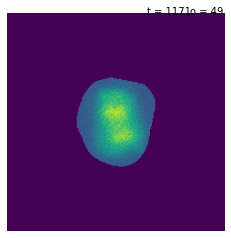

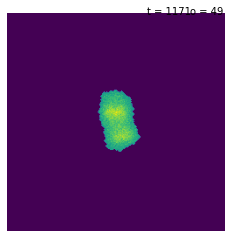

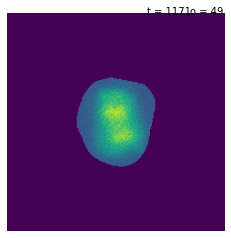

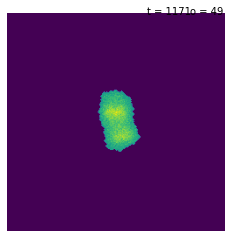

In [27]:
#----------------find long sub traj in a family---------------
for posi in range(1,posi_end+1):
    
    posi_label = 'XY' + str(posi)
    print(posi_label)
    dir_path=output_path+posi_label+'/'
    
    cells_path=dir_path+'cells/'
    fluor_img_path=drive_path+posi_label+'_C2/'
    fluor_img_list=sorted(listdir(fluor_img_path))
    seg_path=output_path+posi_label+'/seg/'
    seg_list=sorted(listdir(seg_path))
 
    df=pd.read_csv(dir_path+'Per_Object_relink.csv')
    am_record=pd.read_csv(dir_path+'am_record.csv')
    traj_df=pd.read_csv(dir_path+'intact-traj_object_num.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record.csv')
    with open (cells_path+'pcna_cells-02', 'rb') as fp:
        cells = pickle.load(fp)

    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values

    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]

    for traj_label in range(1,traj_quan+1):
        print('now processing trajectory ' + str(traj_label))
        cur_traj=traj_record[traj_label-1,:]
        
        if len(np.where(cur_traj!=-1)[0]):
        
            family_tree={}
            family_tree=find_offspring(df,mitosis_df,family_tree,traj_label=traj_label)
            print('family',family_tree)
            all_branches=list(list(parse(traj_label, family_tree)))
            print('all branch',all_branches)

            for branch in all_branches:
                branch_end_label=branch[-1]
                branch_end_traj=traj_record[branch_end_label-1,:]
                for sub_label in branch:
                    
                    print('    commencing sub-traj ' + str(sub_label))
                    sub_traj=traj_record[sub_label-1,:]
                    if len(np.where(sub_traj!=-1)[0]):
                        sub_start_t=np.where(sub_traj!=-1)[0][0]+1
                        sub_end_t=np.where(sub_traj!=-1)[0][-1]+1

                        if (sub_end_t-sub_start_t)>=traj_len_thres:

                            print('        traj length threshold approved')
                            divide_points=[]
                            traj_name=str(sub_label)

                            traj_feature,traj_contour,\
                                traj_cord,traj_seri,traj_am_flag,\
                                traj_vim_feature_values,traj_vim_pca_cord,\
                                traj_pcna_feature_values,traj_pcna_pca_cord=generate_fluor_long_traj(
                                df,cells,am_record,\
                                traj_df,sub_traj,\
                                ['vimentin','pcna'],feature_list,fluor_feature_name)

                            if len(traj_seri) >= 13:
                                print('            traj length seri len satisfactory')
                                traj_sct=fluor_single_cell_traj(traj_seri,traj_contour)
                                traj_sct.set_traj_feature(traj_feature)
                                traj_sct.set_traj_cord(traj_cord)
                                traj_sct.set_traj_divide_points(np.array(divide_points))
                                traj_sct.set_traj_am_flag(traj_am_flag)

                                traj_sct.set_traj_fluor_features('vimentin',feature_list,traj_vim_feature_values)
                                traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[0],traj_vim_pca_cord)

                                traj_sct.set_traj_fluor_features('pcna',feature_list,traj_pcna_feature_values)
                                traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[1],traj_pcna_pca_cord)

                                with open(sct_path+'sub_'+posi_label+'_'+traj_name, 'wb') as fp:
                                    pickle.dump(traj_sct, fp)


                                board_size=250

                                fig=plt.figure()
                                ax = fig.add_subplot(111)
                                ims=[]
                                for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:
                                    img_num=img_num.astype(np.int)
                                    obj_num=obj_num.astype(np.int)
                                    if obj_num!=-1:
                                        img=imread(fluor_img_path+fluor_img_list[img_num-1])
                                        seg_img=imread(seg_path+seg_list[img_num-1])
                                        crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
                                        x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
                                        x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                        cell_on_board=np.zeros((board_size,board_size))
                                        cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell
                                        plt.axis('off')
                                        im=plt.imshow(cell_on_board,animated=True)
                                        t = ax.annotate('t = ' + str(img_num),(160,1))
                                        o = ax.annotate('o = ' + str(obj_num),(210,1))
                                        ims.append([im,t,o])

                                ani = animation.ArtistAnimation(fig, ims)
                                Writer = animation.writers['ffmpeg']
                                writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                                ani.save(cell_ani_path+'sub_pcna_'+posi_label+'_'+traj_name+'.mp4',writer)

                                fig=plt.figure()
                                ax = fig.add_subplot(111)
                                ims=[]
                                for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:

                                    img_num=img_num.astype(np.int)
                                    obj_num=obj_num.astype(np.int)

                                    img=imread(fluor_img_path+fluor_img_list[img_num-1])
                                    seg=imread(seg_path+seg_list[img_num-1])

                                    if obj_num!=-1:

                                        rps=regionprops(seg)
                                        candi_r=[r for r in rps if r.label==obj_num][0]
                                        candi_box=candi_r.bbox

                                        cell_mask = (seg == obj_num)
                                        region_cell_mask = cell_mask[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                        crop_img = img[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                        cell_img = (img*cell_mask)[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]

                                        nuc_mask=cell_img>otsu(cell_img,selem=disk(max(cell_img.shape)/2), mask=cell_img>0)
                                        nuc_mask=remove_small_objects(opening(nuc_mask),100)
                                        nuc_mask=closing(nuc_mask)
                                        nuc_mask=remove_small_holes(nuc_mask,100)

                                        nuc_img=cell_img*nuc_mask

                                        x_c,y_c=nuc_img.shape[0]//2,nuc_img.shape[1]//2
                                        x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                        cell_on_board=np.zeros((board_size,board_size))
                                        cell_on_board[x_l:x_l+nuc_img.shape[0],y_l:y_l+nuc_img.shape[1]]=nuc_img
                                        plt.axis('off')
                                        im=plt.imshow(cell_on_board,animated=True)
                                        t = ax.annotate('t = ' + str(img_num),(160,1))
                                        o = ax.annotate('o = ' + str(obj_num),(210,1))
                                        ims.append([im,t,o])

                #                 ani = animation.ArtistAnimation(fig, ims)
                                ani = animation.ArtistAnimation(fig, ims)
                                Writer = animation.writers['ffmpeg']
                                writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                                ani.save(cell_nuc_ani_path+'sub_pcna_'+posi_label+'_'+traj_name+'.mp4',writer)

XY1
family {}
all branch [[1]]
family {}
all branch [[2]]
family {}
all branch [[3]]
this cell has pca cord
6
this cell has pca cord
6
family {4: [15, 16]}
all branch [[4, 15], [4, 16]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[5]]
family {}
all branch [[6]]
family {7: [100, 101]}
all branch [[7, 100], [7, 101]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[8]]
family {}
all branch [[9]]
family {}
all branch [[10]]
family {11: [37, 38]}
all branch [[11, 37], [11, 38]]
family {12: [58, 57]}
all branch [[12, 58], [12, 57]]
family {13: [48, 49]}
all branch [[13, 48], [13, 49]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[14]]
family {}
all branch [[15]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[16]]
family {17: [39, 40], 40: [176, 177]}
all branch [[17, 39], [17, 40, 176], [1

this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[254]]
family {}
all branch [[255]]
family {}
all branch [[256]]
family {}
all branch [[257]]
family {}
all branch [[258]]
family {}
all branch [[259]]
family {}
all branch [[260]]
family {}
all branch [[261]]
family {}
all branch [[262]]
family {}
all branch [[263]]
family {}
all branch [[264]]
family {}
all branch [[265]]
family {}
all branch [[266]]
family {}
all branch [[267]]
family {}
all branch [[268]]
family {}
all branch [[269]]
family {}
all branch [[270]]
family {}
all branch [[271]]
family {}
all branch [[272]]
family {}
all branch [[273]]
family {}
all branch [[274]]
family {275: [418, 416], 418: [455, 456]}
all branch [[275, 418, 455], [275, 418, 456], [275, 416]]
family {}
all branch [[276]]
family {}
all branch [[277]]
family {278: [585, 582], 582: [1160, 1159]}
all branch [[278, 585], [278, 582, 1160], [278, 582, 1159]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this

family {}
all branch [[491]]
family {}
all branch [[492]]
family {}
all branch [[493]]
family {}
all branch [[494]]
family {}
all branch [[495]]
family {}
all branch [[496]]
family {}
all branch [[497]]
family {}
all branch [[498]]
family {}
all branch [[499]]
family {}
all branch [[500]]
family {}
all branch [[501]]
family {}
all branch [[502]]
family {}
all branch [[503]]
family {}
all branch [[504]]
family {}
all branch [[505]]
family {}
all branch [[506]]
family {}
all branch [[507]]
family {}
all branch [[508]]
family {}
all branch [[509]]
family {}
all branch [[510]]
this cell has pca cord
6
this cell has pca cord
6
family {511: [608, 609]}
all branch [[511, 608], [511, 609]]
family {512: [574, 573], 573: [664, 665]}
all branch [[512, 574], [512, 573, 664], [512, 573, 665]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[513]]
family {}
all branch [[514]]
family {}
all branch [[515]]
family {}
all branch [[516]]
family {}
all branch [[517]]
family {}
all 

family {}
all branch [[742]]
family {}
all branch [[743]]
family {}
all branch [[744]]
family {}
all branch [[745]]
family {}
all branch [[746]]
family {}
all branch [[747]]
family {}
all branch [[748]]
family {}
all branch [[749]]
family {}
all branch [[750]]
family {}
all branch [[751]]
family {}
all branch [[752]]
family {}
all branch [[753]]
family {}
all branch [[754]]
family {}
all branch [[755]]
family {}
all branch [[756]]
family {}
all branch [[757]]
family {}
all branch [[758]]
family {}
all branch [[759]]
family {}
all branch [[760]]
family {}
all branch [[761]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[762]]
family {}
all branch [[763]]
family {}
all branch [[764]]
family {}
all branch [[765]]
family {}
all branch [[766]]
family {}
all branch [[767]]
family {}
all branch [[768]]
family {}
all branch [[769]]
family {}
all branch [[770]]
family {}
all branch [[771]]
family {}
all branch [[772]]
family {}
all branch [[773]]
family {}
all branch [

family {}
all branch [[1045]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1046]]
family {}
all branch [[1047]]
family {}
all branch [[1048]]
family {}
all branch [[1049]]
family {}
all branch [[1050]]
family {}
all branch [[1051]]
family {}
all branch [[1052]]
family {}
all branch [[1053]]
family {}
all branch [[1054]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1055]]
family {}
all branch [[1056]]
family {}
all branch [[1057]]
family {}
all branch [[1058]]
family {}
all branch [[1059]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1060]]
family {}
all branch [[1061]]
family {}
all branch [[1062]]
family {}
all branch [[1063]]
family {}
all branch [[1064]]
family {}
all branch [[1065]]
family {}
all branch [[1066]]
family {}
all branch [[1067]]
family {}
all branch [[1068]]
family {}
all branch [[1069]]
family {}
all branch [[1070]]
family {}
all branch [[1071]]
family {}
all branch [[1072]]
family {}


family {}
all branch [[1287]]
family {}
all branch [[1288]]
family {}
all branch [[1289]]
family {}
all branch [[1290]]
family {}
all branch [[1291]]
family {}
all branch [[1292]]
family {}
all branch [[1293]]
family {}
all branch [[1294]]
family {}
all branch [[1295]]
family {}
all branch [[1296]]
family {}
all branch [[1297]]
family {}
all branch [[1298]]
family {}
all branch [[1299]]
family {}
all branch [[1300]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1301]]
family {}
all branch [[1302]]
family {1303: [1463, 1462]}
all branch [[1303, 1463], [1303, 1462]]
family {}
all branch [[1304]]
family {}
all branch [[1305]]
family {}
all branch [[1306]]
family {}
all branch [[1307]]
family {}
all branch [[1308]]
family {}
all branch [[1309]]
family {}
all branch [[1310]]
family {}
all branch [[1311]]
family {}
all branch [[1312]]
family {}
all branch [[1313]]
family {}
all branch [[1314]]
family {}
all branch [[1315]]
family {1316: [1419, 1417]}
all branch [[1

this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1528]]
family {}
all branch [[1529]]
family {}
all branch [[1530]]
family {}
all branch [[1531]]
family {}
all branch [[1532]]
family {}
all branch [[1533]]
family {}
all branch [[1534]]
family {}
all branch [[1535]]
family {}
all branch [[1536]]
family {}
all branch [[1537]]
family {}
all branch [[1538]]
family {}
all branch [[1539]]
family {}
all branch [[1540]]
family {}
all branch [[1541]]
family {}
all branch [[1542]]
family {}
all branch [[1543]]
family {}
all branch [[1544]]
family {}
all branch [[1545]]
family {}
all branch [[1546]]
family {}
all branch [[1547]]
family {1548: [1687, 1686]}
all branch [[1548, 1687], [1548, 1686]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1549]]
family {}
all branch [[1550]]
family {}
all branch [[1551]]
family {}
all branch [[1552]]
family {}
all branch [[1553]]
family {}
all branch [[1554]]
family {}
all branch [[1555]]
family {}
all branch [

family {}
all branch [[1819]]
family {}
all branch [[1820]]
family {}
all branch [[1821]]
family {}
all branch [[1822]]
family {}
all branch [[1823]]
family {}
all branch [[1824]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1825]]
family {}
all branch [[1826]]
family {}
all branch [[1827]]
family {}
all branch [[1828]]
family {}
all branch [[1829]]
family {}
all branch [[1830]]
family {}
all branch [[1831]]
family {}
all branch [[1832]]
family {}
all branch [[1833]]
family {}
all branch [[1834]]
family {}
all branch [[1835]]
family {}
all branch [[1836]]
family {}
all branch [[1837]]
family {}
all branch [[1838]]
family {}
all branch [[1839]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1840]]
family {}
all branch [[1841]]
family {}
all branch [[1842]]
family {}
all branch [[1843]]
family {}
all branch [[1844]]
family {}
all branch [[1845]]
family {}
all branch [[1846]]
family {}
all branch [[1847]]
family {}
all branch [[1848]]


family {}
all branch [[2104]]
family {}
all branch [[2105]]
family {}
all branch [[2106]]
family {}
all branch [[2107]]
family {}
all branch [[2108]]
family {}
all branch [[2109]]
family {}
all branch [[2110]]
family {}
all branch [[2111]]
family {}
all branch [[2112]]
family {}
all branch [[2113]]
family {}
all branch [[2114]]
family {}
all branch [[2115]]
family {2116: [2586, 2585]}
all branch [[2116, 2586], [2116, 2585]]
family {}
all branch [[2117]]
family {}
all branch [[2118]]
family {}
all branch [[2119]]
family {}
all branch [[2120]]
family {}
all branch [[2121]]
family {}
all branch [[2122]]
family {}
all branch [[2123]]
family {}
all branch [[2124]]
family {}
all branch [[2125]]
family {}
all branch [[2126]]
family {}
all branch [[2127]]
family {}
all branch [[2128]]
family {}
all branch [[2129]]
family {}
all branch [[2130]]
family {}
all branch [[2131]]
family {}
all branch [[2132]]
family {}
all branch [[2133]]
family {}
all branch [[2134]]
family {}
all branch [[2135]]
fa

family {}
all branch [[2395]]
family {}
all branch [[2396]]
family {}
all branch [[2397]]
family {}
all branch [[2398]]
family {}
all branch [[2399]]
family {}
all branch [[2400]]
family {}
all branch [[2401]]
family {}
all branch [[2402]]
family {}
all branch [[2403]]
family {}
all branch [[2404]]
family {}
all branch [[2405]]
family {}
all branch [[2406]]
family {}
all branch [[2407]]
family {2408: [2550, 2549]}
all branch [[2408, 2550], [2408, 2549]]
family {2409: [2432, 2430]}
all branch [[2409, 2432], [2409, 2430]]
family {}
all branch [[2410]]
family {}
all branch [[2411]]
family {}
all branch [[2412]]
family {}
all branch [[2413]]
family {}
all branch [[2414]]
family {}
all branch [[2415]]
family {}
all branch [[2416]]
family {}
all branch [[2417]]
family {}
all branch [[2418]]
family {}
all branch [[2419]]
family {}
all branch [[2420]]
family {}
all branch [[2421]]
family {}
all branch [[2422]]
family {}
all branch [[2423]]
family {}
all branch [[2424]]
family {}
all branch [[2

family {}
all branch [[2668]]
family {}
all branch [[2669]]
family {}
all branch [[2670]]
family {}
all branch [[2671]]
family {}
all branch [[2672]]
family {}
all branch [[2673]]
family {}
all branch [[2674]]
family {}
all branch [[2675]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2676]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2677]]
family {}
all branch [[2678]]
family {}
all branch [[2679]]
family {}
all branch [[2680]]
family {}
all branch [[2681]]
family {}
all branch [[2682]]
family {}
all branch [[2683]]
family {}
all branch [[2684]]
family {}
all branch [[2685]]
family {}
all branch [[2686]]
family {}
all branch [[2687]]
family {}
all branch [[2688]]
family {}
all branch [[2689]]
family {}
all branch [[2690]]
family {}
all branch [[2691]]
family {}
all branch [[2692]]
family {}
all branch [[2693]]
family {}
all branch [[2694]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2695]]
family {}


family {}
all branch [[2924]]
family {}
all branch [[2925]]
family {}
all branch [[2926]]
family {}
all branch [[2927]]
family {}
all branch [[2928]]
family {}
all branch [[2929]]
family {}
all branch [[2930]]
family {}
all branch [[2931]]
family {}
all branch [[2932]]
family {}
all branch [[2933]]
family {}
all branch [[2934]]
family {}
all branch [[2935]]
family {}
all branch [[2936]]
family {}
all branch [[2937]]
family {}
all branch [[2938]]
family {}
all branch [[2939]]
family {}
all branch [[2940]]
family {}
all branch [[2941]]
family {}
all branch [[2942]]
family {}
all branch [[2943]]
family {}
all branch [[2944]]
family {}
all branch [[2945]]
family {}
all branch [[2946]]
family {}
all branch [[2947]]
family {}
all branch [[2948]]
family {}
all branch [[2949]]
family {}
all branch [[2950]]
family {}
all branch [[2951]]
family {}
all branch [[2952]]
family {}
all branch [[2953]]
family {}
all branch [[2954]]
family {}
all branch [[2955]]
family {}
all branch [[2956]]
family {}


family {}
all branch [[3232]]
family {3233: [3338, 3337]}
all branch [[3233, 3338], [3233, 3337]]
family {}
all branch [[3234]]
family {}
all branch [[3235]]
family {}
all branch [[3236]]
family {}
all branch [[3237]]
family {}
all branch [[3238]]
family {}
all branch [[3239]]
family {}
all branch [[3240]]
family {}
all branch [[3241]]
family {}
all branch [[3242]]
family {3243: [3408, 3410]}
all branch [[3243, 3408], [3243, 3410]]
family {}
all branch [[3244]]
family {}
all branch [[3245]]
family {}
all branch [[3246]]
family {}
all branch [[3247]]
family {}
all branch [[3248]]
family {}
all branch [[3249]]
family {}
all branch [[3250]]
family {}
all branch [[3251]]
family {}
all branch [[3252]]
family {}
all branch [[3253]]
family {}
all branch [[3254]]
family {}
all branch [[3255]]
family {}
all branch [[3256]]
family {}
all branch [[3257]]
family {}
all branch [[3258]]
family {}
all branch [[3259]]
family {}
all branch [[3260]]
family {}
all branch [[3261]]
family {}
all branch [[3

family {}
all branch [[3534]]
family {}
all branch [[3535]]
family {}
all branch [[3536]]
family {}
all branch [[3537]]
family {}
all branch [[3538]]
family {}
all branch [[3539]]
family {}
all branch [[3540]]
family {}
all branch [[3541]]
family {3542: [3695, 3693]}
all branch [[3542, 3695], [3542, 3693]]
family {}
all branch [[3543]]
family {}
all branch [[3544]]
family {}
all branch [[3545]]
family {}
all branch [[3546]]
family {}
all branch [[3547]]
family {}
all branch [[3548]]
family {}
all branch [[3549]]
family {}
all branch [[3550]]
family {}
all branch [[3551]]
family {}
all branch [[3552]]
family {}
all branch [[3553]]
family {}
all branch [[3554]]
family {}
all branch [[3555]]
family {}
all branch [[3556]]
family {}
all branch [[3557]]
family {}
all branch [[3558]]
family {}
all branch [[3559]]
family {}
all branch [[3560]]
family {}
all branch [[3561]]
family {}
all branch [[3562]]
family {}
all branch [[3563]]
family {}
all branch [[3564]]
family {}
all branch [[3565]]
fa

family {}
all branch [[3813]]
family {}
all branch [[3814]]
family {}
all branch [[3815]]
family {}
all branch [[3816]]
family {}
all branch [[3817]]
family {3818: [3933, 3936]}
all branch [[3818, 3933], [3818, 3936]]
family {}
all branch [[3819]]
family {}
all branch [[3820]]
family {}
all branch [[3821]]
family {}
all branch [[3822]]
family {}
all branch [[3823]]
family {3824: [3872, 3869]}
all branch [[3824, 3872], [3824, 3869]]
family {}
all branch [[3825]]
family {}
all branch [[3826]]
family {}
all branch [[3827]]
family {}
all branch [[3828]]
family {}
all branch [[3829]]
family {}
all branch [[3830]]
family {}
all branch [[3831]]
family {}
all branch [[3832]]
family {}
all branch [[3833]]
family {}
all branch [[3834]]
family {}
all branch [[3835]]
family {}
all branch [[3836]]
family {}
all branch [[3837]]
family {}
all branch [[3838]]
family {}
all branch [[3839]]
family {}
all branch [[3840]]
family {}
all branch [[3841]]
family {}
all branch [[3842]]
family {}
all branch [[3

family {}
all branch [[4147]]
family {}
all branch [[4148]]
family {}
all branch [[4149]]
family {}
all branch [[4150]]
family {}
all branch [[4151]]
family {}
all branch [[4152]]
family {}
all branch [[4153]]
family {}
all branch [[4154]]
family {}
all branch [[4155]]
family {}
all branch [[4156]]
family {}
all branch [[4157]]
family {}
all branch [[4158]]
family {}
all branch [[4159]]
family {}
all branch [[4160]]
family {4161: [4176, 4175]}
all branch [[4161, 4176], [4161, 4175]]
family {}
all branch [[4162]]
family {}
all branch [[4163]]
family {}
all branch [[4164]]
family {}
all branch [[4165]]
family {}
all branch [[4166]]
family {}
all branch [[4167]]
family {}
all branch [[4168]]
family {}
all branch [[4169]]
family {}
all branch [[4170]]
family {}
all branch [[4171]]
family {}
all branch [[4172]]
family {}
all branch [[4173]]
family {}
all branch [[4174]]
family {}
all branch [[4175]]
family {}
all branch [[4176]]
family {}
all branch [[4177]]
family {}
all branch [[4178]]
fa

this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[103]]
family {}
all branch [[104]]
family {}
all branch [[105]]
family {}
all branch [[106]]
family {}
all branch [[107]]
family {}
all branch [[108]]
family {}
all branch [[109]]
family {}
all branch [[110]]
family {}
all branch [[111]]
family {}
all branch [[112]]
family {}
all branch [[113]]
family {}
all branch [[114]]
family {}
all branch [[115]]
family {}
all branch [[116]]
family {}
all branch [[117]]
family {}
all branch [[118]]
family {}
all branch [[119]]
family {}
all branch [[120]]
family {}
all branch [[121]]
family {}
all branch [[122]]
family {}
all branch [[123]]
family {}
all branch [[124]]
family {}
all branch [[125]]
family {}
all branch [[126]]
family {}
all branch [[127]]
family {}
all branch [[128]]
family {}
all branch [[129]]
family {}
all branch [[130]]
family {}
all branch [[131]]
family {}
all branch [[132]]
family {}
all branch [[133]]
family {}
all branch [[134]]
family {}
all branch [

family {}
all branch [[355]]
family {}
all branch [[356]]
family {}
all branch [[357]]
family {}
all branch [[358]]
family {}
all branch [[359]]
family {}
all branch [[360]]
family {}
all branch [[361]]
family {}
all branch [[362]]
family {}
all branch [[363]]
family {}
all branch [[364]]
family {}
all branch [[365]]
family {}
all branch [[366]]
family {}
all branch [[367]]
family {}
all branch [[368]]
family {}
all branch [[369]]
family {}
all branch [[370]]
family {}
all branch [[371]]
family {}
all branch [[372]]
family {}
all branch [[373]]
family {}
all branch [[374]]
family {}
all branch [[375]]
family {}
all branch [[376]]
family {}
all branch [[377]]
family {}
all branch [[378]]
family {}
all branch [[379]]
family {}
all branch [[380]]
family {}
all branch [[381]]
family {}
all branch [[382]]
family {}
all branch [[383]]
family {}
all branch [[384]]
family {}
all branch [[385]]
family {}
all branch [[386]]
family {}
all branch [[387]]
family {}
all branch [[388]]
family {}
all 

family {}
all branch [[660]]
family {}
all branch [[661]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[662]]
family {}
all branch [[663]]
family {}
all branch [[664]]
family {}
all branch [[665]]
family {}
all branch [[666]]
family {}
all branch [[667]]
family {}
all branch [[668]]
family {}
all branch [[669]]
family {}
all branch [[670]]
family {}
all branch [[671]]
family {}
all branch [[672]]
family {}
all branch [[673]]
family {}
all branch [[674]]
family {}
all branch [[675]]
family {}
all branch [[676]]
family {}
all branch [[677]]
family {}
all branch [[678]]
family {}
all branch [[679]]
family {}
all branch [[680]]
family {}
all branch [[681]]
family {}
all branch [[682]]
family {}
all branch [[683]]
family {}
all branch [[684]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[685]]
family {}
all branch [[686]]
family {}
all branch [[687]]
family {}
all branch [[688]]
family {}
all branch [[689]]
this cell has pca cord
6
this 

family {}
all branch [[925]]
family {}
all branch [[926]]
family {}
all branch [[927]]
family {}
all branch [[928]]
family {}
all branch [[929]]
family {}
all branch [[930]]
family {}
all branch [[931]]
family {}
all branch [[932]]
family {}
all branch [[933]]
family {}
all branch [[934]]
family {}
all branch [[935]]
family {}
all branch [[936]]
family {}
all branch [[937]]
family {}
all branch [[938]]
family {}
all branch [[939]]
family {}
all branch [[940]]
family {}
all branch [[941]]
family {}
all branch [[942]]
family {}
all branch [[943]]
family {}
all branch [[944]]
family {}
all branch [[945]]
family {}
all branch [[946]]
family {}
all branch [[947]]
family {}
all branch [[948]]
family {}
all branch [[949]]
family {}
all branch [[950]]
family {}
all branch [[951]]
family {}
all branch [[952]]
family {}
all branch [[953]]
family {}
all branch [[954]]
family {}
all branch [[955]]
family {}
all branch [[956]]
family {}
all branch [[957]]
family {}
all branch [[958]]
family {}
all 

family {}
all branch [[1224]]
family {}
all branch [[1225]]
family {}
all branch [[1226]]
family {}
all branch [[1227]]
family {}
all branch [[1228]]
family {}
all branch [[1229]]
family {}
all branch [[1230]]
family {}
all branch [[1231]]
family {}
all branch [[1232]]
family {}
all branch [[1233]]
family {}
all branch [[1234]]
family {}
all branch [[1235]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1236]]
family {}
all branch [[1237]]
family {}
all branch [[1238]]
family {}
all branch [[1239]]
family {}
all branch [[1240]]
family {}
all branch [[1241]]
family {}
all branch [[1242]]
family {}
all branch [[1243]]
family {}
all branch [[1244]]
family {}
all branch [[1245]]
family {}
all branch [[1246]]
family {}
all branch [[1247]]
family {}
all branch [[1248]]
family {}
all branch [[1249]]
family {}
all branch [[1250]]
family {}
all branch [[1251]]
family {}
all branch [[1252]]
family {}
all branch [[1253]]
family {}
all branch [[1254]]
family {}
all branch

family {}
all branch [[1479]]
family {}
all branch [[1480]]
family {1481: [1602, 1600]}
all branch [[1481, 1602], [1481, 1600]]
family {}
all branch [[1482]]
family {}
all branch [[1483]]
family {}
all branch [[1484]]
family {}
all branch [[1485]]
family {}
all branch [[1486]]
family {}
all branch [[1487]]
family {}
all branch [[1488]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1489]]
family {}
all branch [[1490]]
family {}
all branch [[1491]]
family {}
all branch [[1492]]
family {}
all branch [[1493]]
family {}
all branch [[1494]]
family {}
all branch [[1495]]
family {}
all branch [[1496]]
family {}
all branch [[1497]]
family {}
all branch [[1498]]
family {}
all branch [[1499]]
family {}
all branch [[1500]]
family {}
all branch [[1501]]
family {}
all branch [[1502]]
family {}
all branch [[1503]]
family {}
all branch [[1504]]
family {}
all branch [[1505]]
family {}
all branch [[1506]]
family {}
all branch [[1507]]
family {}
all branch [[1508]]
family {}
al

family {}
all branch [[1717]]
family {}
all branch [[1718]]
family {}
all branch [[1719]]
family {}
all branch [[1720]]
family {}
all branch [[1721]]
family {}
all branch [[1722]]
family {}
all branch [[1723]]
family {}
all branch [[1724]]
family {}
all branch [[1725]]
family {}
all branch [[1726]]
family {}
all branch [[1727]]
family {}
all branch [[1728]]
family {}
all branch [[1729]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1730]]
family {}
all branch [[1731]]
family {}
all branch [[1732]]
family {}
all branch [[1733]]
family {}
all branch [[1734]]
family {}
all branch [[1735]]
family {}
all branch [[1736]]
family {}
all branch [[1737]]
family {}
all branch [[1738]]
family {}
all branch [[1739]]
family {}
all branch [[1740]]
family {}
all branch [[1741]]
family {}
all branch [[1742]]
family {}
all branch [[1743]]
family {}
all branch [[1744]]
family {}
all branch [[1745]]
family {}
all branch [[1746]]
family {}
all branch [[1747]]
this cell has pca co

family {}
all branch [[1983]]
family {}
all branch [[1984]]
family {}
all branch [[1985]]
family {}
all branch [[1986]]
family {}
all branch [[1987]]
family {}
all branch [[1988]]
family {}
all branch [[1989]]
family {}
all branch [[1990]]
family {}
all branch [[1991]]
family {}
all branch [[1992]]
family {}
all branch [[1993]]
family {}
all branch [[1994]]
family {}
all branch [[1995]]
family {}
all branch [[1996]]
family {}
all branch [[1997]]
family {}
all branch [[1998]]
family {}
all branch [[1999]]
family {}
all branch [[2000]]
family {}
all branch [[2001]]
family {}
all branch [[2002]]
family {}
all branch [[2003]]
family {}
all branch [[2004]]
family {2005: [2118, 2120]}
all branch [[2005, 2118], [2005, 2120]]
family {}
all branch [[2006]]
family {}
all branch [[2007]]
family {}
all branch [[2008]]
family {}
all branch [[2009]]
family {}
all branch [[2010]]
family {}
all branch [[2011]]
family {}
all branch [[2012]]
family {}
all branch [[2013]]
family {}
all branch [[2014]]
fa

family {}
all branch [[2237]]
family {}
all branch [[2238]]
family {}
all branch [[2239]]
family {}
all branch [[2240]]
family {}
all branch [[2241]]
family {}
all branch [[2242]]
family {}
all branch [[2243]]
family {}
all branch [[2244]]
family {}
all branch [[2245]]
family {}
all branch [[2246]]
family {}
all branch [[2247]]
family {}
all branch [[2248]]
family {}
all branch [[2249]]
family {}
all branch [[2250]]
family {}
all branch [[2251]]
family {}
all branch [[2252]]
family {}
all branch [[2253]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2254]]
family {}
all branch [[2255]]
family {}
all branch [[2256]]
family {}
all branch [[2257]]
family {}
all branch [[2258]]
family {}
all branch [[2259]]
family {}
all branch [[2260]]
family {}
all branch [[2261]]
family {}
all branch [[2262]]
family {}
all branch [[2263]]
family {}
all branch [[2264]]
family {}
all branch [[2265]]
family {}
all branch [[2266]]
family {}
all branch [[2267]]
family {}
all branch

family {}
all branch [[2485]]
family {}
all branch [[2486]]
family {}
all branch [[2487]]
family {}
all branch [[2488]]
family {}
all branch [[2489]]
family {}
all branch [[2490]]
family {}
all branch [[2491]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2492]]
family {}
all branch [[2493]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2494]]
family {}
all branch [[2495]]
family {}
all branch [[2496]]
family {}
all branch [[2497]]
family {}
all branch [[2498]]
family {}
all branch [[2499]]
family {}
all branch [[2500]]
family {}
all branch [[2501]]
family {}
all branch [[2502]]
family {}
all branch [[2503]]
family {}
all branch [[2504]]
family {}
all branch [[2505]]
family {}
all branch [[2506]]
family {}
all branch [[2507]]
family {}
all branch [[2508]]
family {}
all branch [[2509]]
family {}
all branch [[2510]]
family {}
all branch [[2511]]
family {}
all branch [[2512]]
family {}
all branch [[2513]]
family {}
all branch [[2514]]


this cell has pca cord
6
this cell has pca cord
6
family {2739: [3410, 3417]}
all branch [[2739, 3410], [2739, 3417]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2740]]
family {}
all branch [[2741]]
family {}
all branch [[2742]]
family {}
all branch [[2743]]
family {2744: [3087, 3089]}
all branch [[2744, 3087], [2744, 3089]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2745]]
family {}
all branch [[2746]]
family {}
all branch [[2747]]
family {}
all branch [[2748]]
family {}
all branch [[2749]]
family {}
all branch [[2750]]
family {2751: [2890, 2889]}
all branch [[2751, 2890], [2751, 2889]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2752]]
family {}
all branch [[2753]]
family {}
all branch [[2754]]
family {}
all branch [[2755]]
family {}
all branch [[2756]]
family {}
all branch [[2757]]
family {}
all branch [[2758]]
family {}
all branch [[2759]]
family

family {}
all branch [[2987]]
family {}
all branch [[2988]]
family {}
all branch [[2989]]
family {}
all branch [[2990]]
family {}
all branch [[2991]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2992]]
family {}
all branch [[2993]]
family {}
all branch [[2994]]
family {}
all branch [[2995]]
family {}
all branch [[2996]]
family {}
all branch [[2997]]
family {}
all branch [[2998]]
family {}
all branch [[2999]]
family {}
all branch [[3000]]
family {}
all branch [[3001]]
family {}
all branch [[3002]]
family {}
all branch [[3003]]
family {}
all branch [[3004]]
family {}
all branch [[3005]]
family {}
all branch [[3006]]
family {}
all branch [[3007]]
family {}
all branch [[3008]]
family {}
all branch [[3009]]
family {}
all branch [[3010]]
family {}
all branch [[3011]]
family {}
all branch [[3012]]
family {}
all branch [[3013]]
family {}
all branch [[3014]]
family {}
all branch [[3015]]
family {}
all branch [[3016]]
family {}
all branch [[3017]]
family {}
all branch

family {}
all branch [[3278]]
family {}
all branch [[3279]]
family {}
all branch [[3280]]
family {}
all branch [[3281]]
family {}
all branch [[3282]]
family {}
all branch [[3283]]
family {}
all branch [[3284]]
family {}
all branch [[3285]]
family {}
all branch [[3286]]
family {}
all branch [[3287]]
family {}
all branch [[3288]]
family {}
all branch [[3289]]
family {}
all branch [[3290]]
family {}
all branch [[3291]]
family {}
all branch [[3292]]
family {}
all branch [[3293]]
family {3294: [3475, 3471]}
all branch [[3294, 3475], [3294, 3471]]
family {}
all branch [[3295]]
family {}
all branch [[3296]]
family {}
all branch [[3297]]
family {}
all branch [[3298]]
family {}
all branch [[3299]]
family {}
all branch [[3300]]
family {}
all branch [[3301]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[3302]]
family {}
all branch [[3303]]
family {}
all branch [[3304]]
family {}
all branch [[3305]]
family {3306: [3592, 3593], 3592: [3836, 3832]}
all branch [[3306, 3592,

family {}
all branch [[3559]]
family {}
all branch [[3560]]
family {}
all branch [[3561]]
family {}
all branch [[3562]]
family {}
all branch [[3563]]
family {}
all branch [[3564]]
family {}
all branch [[3565]]
family {}
all branch [[3566]]
family {}
all branch [[3567]]
family {}
all branch [[3568]]
family {}
all branch [[3569]]
family {}
all branch [[3570]]
family {3571: [3712, 3705]}
all branch [[3571, 3712], [3571, 3705]]
family {}
all branch [[3572]]
family {}
all branch [[3573]]
family {}
all branch [[3574]]
family {}
all branch [[3575]]
family {}
all branch [[3576]]
family {}
all branch [[3577]]
family {}
all branch [[3578]]
family {}
all branch [[3579]]
family {}
all branch [[3580]]
family {}
all branch [[3581]]
family {}
all branch [[3582]]
family {}
all branch [[3583]]
family {}
all branch [[3584]]
family {}
all branch [[3585]]
family {}
all branch [[3586]]
family {}
all branch [[3587]]
family {}
all branch [[3588]]
family {}
all branch [[3589]]
family {}
all branch [[3590]]
fa

family {}
all branch [[3822]]
family {}
all branch [[3823]]
family {}
all branch [[3824]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[3825]]
family {}
all branch [[3826]]
family {}
all branch [[3827]]
family {}
all branch [[3828]]
family {}
all branch [[3829]]
family {}
all branch [[3830]]
family {}
all branch [[3831]]
family {}
all branch [[3832]]
family {}
all branch [[3833]]
family {}
all branch [[3834]]
family {}
all branch [[3835]]
family {}
all branch [[3836]]
family {}
all branch [[3837]]
family {}
all branch [[3838]]
family {}
all branch [[3839]]
family {}
all branch [[3840]]
family {}
all branch [[3841]]
family {}
all branch [[3842]]
family {}
all branch [[3843]]
family {}
all branch [[3844]]
family {}
all branch [[3845]]
family {}
all branch [[3846]]
family {}
all branch [[3847]]
family {}
all branch [[3848]]
family {3849: [4517, 4521]}
all branch [[3849, 4517], [3849, 4521]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord

family {}
all branch [[4086]]
family {}
all branch [[4087]]
family {}
all branch [[4088]]
family {}
all branch [[4089]]
family {}
all branch [[4090]]
family {}
all branch [[4091]]
family {}
all branch [[4092]]
family {}
all branch [[4093]]
family {}
all branch [[4094]]
family {}
all branch [[4095]]
family {}
all branch [[4096]]
family {}
all branch [[4097]]
family {}
all branch [[4098]]
family {}
all branch [[4099]]
family {}
all branch [[4100]]
family {}
all branch [[4101]]
family {}
all branch [[4102]]
family {}
all branch [[4103]]
family {}
all branch [[4104]]
family {}
all branch [[4105]]
family {}
all branch [[4106]]
family {}
all branch [[4107]]
family {}
all branch [[4108]]
family {}
all branch [[4109]]
family {}
all branch [[4110]]
family {}
all branch [[4111]]
family {}
all branch [[4112]]
family {}
all branch [[4113]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[4114]]
family {4115: [4128, 4134]}
all branch [[4115, 4128], [4115, 4134]]
family {}
al

family {}
all branch [[4369]]
family {}
all branch [[4370]]
family {}
all branch [[4371]]
family {}
all branch [[4372]]
family {}
all branch [[4373]]
family {}
all branch [[4374]]
family {}
all branch [[4375]]
family {}
all branch [[4376]]
family {}
all branch [[4377]]
family {}
all branch [[4378]]
family {}
all branch [[4379]]
family {}
all branch [[4380]]
family {}
all branch [[4381]]
family {}
all branch [[4382]]
family {}
all branch [[4383]]
family {}
all branch [[4384]]
family {}
all branch [[4385]]
family {}
all branch [[4386]]
family {}
all branch [[4387]]
family {}
all branch [[4388]]
family {}
all branch [[4389]]
family {}
all branch [[4390]]
family {}
all branch [[4391]]
family {}
all branch [[4392]]
family {}
all branch [[4393]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[4394]]
family {}
all branch [[4395]]
family {}
all branch [[4396]]
family {}
all branch [[4397]]
family {}
all branch [[4398]]
family {}
all branch [[4399]]
family {}
all branch

family {}
all branch [[4639]]
family {}
all branch [[4640]]
family {}
all branch [[4641]]
family {}
all branch [[4642]]
family {}
all branch [[4643]]
family {}
all branch [[4644]]
family {}
all branch [[4645]]
family {}
all branch [[4646]]
family {}
all branch [[4647]]
family {}
all branch [[4648]]
family {}
all branch [[4649]]
family {}
all branch [[4650]]
family {}
all branch [[4651]]
family {}
all branch [[4652]]
family {}
all branch [[4653]]
family {}
all branch [[4654]]
family {}
all branch [[4655]]
family {}
all branch [[4656]]
family {}
all branch [[4657]]
family {}
all branch [[4658]]
family {}
all branch [[4659]]
family {}
all branch [[4660]]
family {}
all branch [[4661]]
family {}
all branch [[4662]]
family {}
all branch [[4663]]
family {}
all branch [[4664]]
family {}
all branch [[4665]]
family {}
all branch [[4666]]
family {}
all branch [[4667]]
family {}
all branch [[4668]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[4669]]
family {}
all branch

family {}
all branch [[4904]]
family {}
all branch [[4905]]
family {}
all branch [[4906]]
family {}
all branch [[4907]]
family {}
all branch [[4908]]
family {}
all branch [[4909]]
family {}
all branch [[4910]]
family {}
all branch [[4911]]
family {}
all branch [[4912]]
family {}
all branch [[4913]]
family {}
all branch [[4914]]
family {}
all branch [[4915]]
family {}
all branch [[4916]]
family {}
all branch [[4917]]
family {}
all branch [[4918]]
family {}
all branch [[4919]]
family {}
all branch [[4920]]
family {}
all branch [[4921]]
family {}
all branch [[4922]]
family {}
all branch [[4923]]
family {}
all branch [[4924]]
family {}
all branch [[4925]]
family {}
all branch [[4926]]
family {}
all branch [[4927]]
family {}
all branch [[4928]]
family {}
all branch [[4929]]
family {}
all branch [[4930]]
family {}
all branch [[4931]]
family {}
all branch [[4932]]
family {}
all branch [[4933]]
family {}
all branch [[4934]]
family {}
all branch [[4935]]
family {}
all branch [[4936]]
family {}


family {}
all branch [[5187]]
family {}
all branch [[5188]]
family {}
all branch [[5189]]
family {}
all branch [[5190]]
family {}
all branch [[5191]]
family {}
all branch [[5192]]
family {}
all branch [[5193]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[5194]]
family {}
all branch [[5195]]
family {}
all branch [[5196]]
family {}
all branch [[5197]]
family {}
all branch [[5198]]
family {}
all branch [[5199]]
family {}
all branch [[5200]]
family {}
all branch [[5201]]
family {}
all branch [[5202]]
family {}
all branch [[5203]]
family {}
all branch [[5204]]
family {}
all branch [[5205]]
family {}
all branch [[5206]]
family {}
all branch [[5207]]
family {}
all branch [[5208]]
family {}
all branch [[5209]]
family {}
all branch [[5210]]
family {}
all branch [[5211]]
family {}
all branch [[5212]]
family {}
all branch [[5213]]
family {}
all branch [[5214]]
family {}
all branch [[5215]]
family {}
all branch [[5216]]
family {}
all branch [[5217]]
family {}
all branch

family {}
all branch [[5448]]
family {}
all branch [[5449]]
family {}
all branch [[5450]]
family {}
all branch [[5451]]
family {}
all branch [[5452]]
family {}
all branch [[5453]]
family {}
all branch [[5454]]
family {}
all branch [[5455]]
family {}
all branch [[5456]]
family {}
all branch [[5457]]
family {}
all branch [[5458]]
family {}
all branch [[5459]]
family {}
all branch [[5460]]
family {}
all branch [[5461]]
family {}
all branch [[5462]]
family {}
all branch [[5463]]
family {}
all branch [[5464]]
family {}
all branch [[5465]]
family {}
all branch [[5466]]
family {}
all branch [[5467]]
family {}
all branch [[5468]]
family {}
all branch [[5469]]
family {}
all branch [[5470]]
family {}
all branch [[5471]]
family {}
all branch [[5472]]
family {}
all branch [[5473]]
family {}
all branch [[5474]]
family {}
all branch [[5475]]
family {}
all branch [[5476]]
family {5477: [5696, 5695]}
all branch [[5477, 5696], [5477, 5695]]
this cell has pca cord
6
this cell has pca cord
6
family {}
al

family {}
all branch [[5696]]
family {}
all branch [[5697]]
family {}
all branch [[5698]]
family {}
all branch [[5699]]
family {}
all branch [[5700]]
family {}
all branch [[5701]]
family {}
all branch [[5702]]
family {}
all branch [[5703]]
family {}
all branch [[5704]]
family {}
all branch [[5705]]
family {}
all branch [[5706]]
family {}
all branch [[5707]]
family {}
all branch [[5708]]
family {}
all branch [[5709]]
family {}
all branch [[5710]]
family {}
all branch [[5711]]
family {}
all branch [[5712]]
family {}
all branch [[5713]]
family {}
all branch [[5714]]
family {}
all branch [[5715]]
family {}
all branch [[5716]]
family {}
all branch [[5717]]
family {}
all branch [[5718]]
family {}
all branch [[5719]]
family {}
all branch [[5720]]
family {}
all branch [[5721]]
family {}
all branch [[5722]]
family {}
all branch [[5723]]
family {}
all branch [[5724]]
family {}
all branch [[5725]]
family {}
all branch [[5726]]
family {}
all branch [[5727]]
family {}
all branch [[5728]]
family {}


family {}
all branch [[5959]]
family {}
all branch [[5960]]
family {}
all branch [[5961]]
family {}
all branch [[5962]]
family {}
all branch [[5963]]
family {}
all branch [[5964]]
family {}
all branch [[5965]]
family {}
all branch [[5966]]
family {}
all branch [[5967]]
family {}
all branch [[5968]]
family {}
all branch [[5969]]
family {}
all branch [[5970]]
family {}
all branch [[5971]]
family {}
all branch [[5972]]
family {}
all branch [[5973]]
family {}
all branch [[5974]]
family {}
all branch [[5975]]
family {}
all branch [[5976]]
family {}
all branch [[5977]]
family {}
all branch [[5978]]
family {}
all branch [[5979]]
family {}
all branch [[5980]]
family {}
all branch [[5981]]
family {}
all branch [[5982]]
family {}
all branch [[5983]]
family {}
all branch [[5984]]
family {}
all branch [[5985]]
family {}
all branch [[5986]]
family {}
all branch [[5987]]
family {}
all branch [[5988]]
family {}
all branch [[5989]]
family {}
all branch [[5990]]
family {}
all branch [[5991]]
family {}


family {}
all branch [[6275]]
family {}
all branch [[6276]]
family {}
all branch [[6277]]
family {}
all branch [[6278]]
family {}
all branch [[6279]]
family {}
all branch [[6280]]
family {6281: [6481, 6494]}
all branch [[6281, 6481], [6281, 6494]]
family {}
all branch [[6282]]
family {}
all branch [[6283]]
family {}
all branch [[6284]]
family {}
all branch [[6285]]
family {}
all branch [[6286]]
family {}
all branch [[6287]]
family {}
all branch [[6288]]
family {}
all branch [[6289]]
family {}
all branch [[6290]]
family {}
all branch [[6291]]
family {}
all branch [[6292]]
family {}
all branch [[6293]]
family {}
all branch [[6294]]
family {}
all branch [[6295]]
family {}
all branch [[6296]]
family {}
all branch [[6297]]
family {}
all branch [[6298]]
family {}
all branch [[6299]]
family {}
all branch [[6300]]
family {}
all branch [[6301]]
family {}
all branch [[6302]]
family {}
all branch [[6303]]
family {}
all branch [[6304]]
family {}
all branch [[6305]]
family {}
all branch [[6306]]
fa

family {}
all branch [[6595]]
family {}
all branch [[6596]]
family {}
all branch [[6597]]
family {}
all branch [[6598]]
family {}
all branch [[6599]]
family {}
all branch [[6600]]
family {}
all branch [[6601]]
family {}
all branch [[6602]]
family {}
all branch [[6603]]
family {}
all branch [[6604]]
family {}
all branch [[6605]]
family {}
all branch [[6606]]
family {}
all branch [[6607]]
family {}
all branch [[6608]]
family {}
all branch [[6609]]
family {}
all branch [[6610]]
family {}
all branch [[6611]]
family {}
all branch [[6612]]
family {}
all branch [[6613]]
family {}
all branch [[6614]]
family {}
all branch [[6615]]
family {}
all branch [[6616]]
family {}
all branch [[6617]]
family {}
all branch [[6618]]
family {}
all branch [[6619]]
family {}
all branch [[6620]]
family {}
all branch [[6621]]
family {}
all branch [[6622]]
family {}
all branch [[6623]]
family {}
all branch [[6624]]
family {}
all branch [[6625]]
family {}
all branch [[6626]]
family {}
all branch [[6627]]
family {}


family {}
all branch [[6902]]
family {}
all branch [[6903]]
family {}
all branch [[6904]]
family {}
all branch [[6905]]
family {}
all branch [[6906]]
family {}
all branch [[6907]]
family {}
all branch [[6908]]
family {}
all branch [[6909]]
family {}
all branch [[6910]]
family {}
all branch [[6911]]
family {}
all branch [[6912]]
family {}
all branch [[6913]]
family {}
all branch [[6914]]
family {}
all branch [[6915]]
family {}
all branch [[6916]]
family {}
all branch [[6917]]
family {}
all branch [[6918]]
family {}
all branch [[6919]]
family {}
all branch [[6920]]
family {}
all branch [[6921]]
family {}
all branch [[6922]]
family {}
all branch [[6923]]
family {}
all branch [[6924]]
family {}
all branch [[6925]]
family {}
all branch [[6926]]
family {}
all branch [[6927]]
family {}
all branch [[6928]]
family {}
all branch [[6929]]
family {}
all branch [[6930]]
family {}
all branch [[6931]]
family {}
all branch [[6932]]
family {}
all branch [[6933]]
family {}
all branch [[6934]]
family {}


this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[142]]
family {}
all branch [[143]]
family {}
all branch [[144]]
family {}
all branch [[145]]
family {}
all branch [[146]]
family {}
all branch [[147]]
family {148: [889, 887]}
all branch [[148, 889], [148, 887]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[149]]
family {}
all branch [[150]]
family {}
all branch [[151]]
family {}
all branch [[152]]
family {}
all branch [[153]]
family {}
all branch [[154]]
family {}
all branch [[155]]
family {}
all branch [[156]]
family {}
all branch [[157]]
family {}
all branch [[158]]
family {}
all branch [[159]]
family {160: [465, 464]}
all branch [[160, 465], [160, 464]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[161]]
family {}
all branch [[162]]
family {}
all branch [[163]]
family {}
all branch [[164]]
family {}
all branc

family {}
all branch [[407]]
family {}
all branch [[408]]
family {}
all branch [[409]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[410]]
family {}
all branch [[411]]
family {}
all branch [[412]]
family {}
all branch [[413]]
family {}
all branch [[414]]
family {}
all branch [[415]]
family {}
all branch [[416]]
family {}
all branch [[417]]
family {}
all branch [[418]]
family {}
all branch [[419]]
family {}
all branch [[420]]
family {}
all branch [[421]]
family {}
all branch [[422]]
family {}
all branch [[423]]
family {}
all branch [[424]]
family {}
all branch [[425]]
family {}
all branch [[426]]
family {}
all branch [[427]]
family {}
all branch [[428]]
family {}
all branch [[429]]
family {430: [523, 524]}
all branch [[430, 523], [430, 524]]
family {}
all branch [[431]]
family {}
all branch [[432]]
family {}
all branch [[433]]
family {}
all branch [[434]]
family {}
all branch [[435]]
family {}
all branch [[436]]
family {}
all branch [[437]]
family {}
all branc

family {}
all branch [[650]]
family {}
all branch [[651]]
family {}
all branch [[652]]
family {}
all branch [[653]]
family {}
all branch [[654]]
family {}
all branch [[655]]
family {}
all branch [[656]]
family {}
all branch [[657]]
family {}
all branch [[658]]
family {}
all branch [[659]]
family {}
all branch [[660]]
family {}
all branch [[661]]
family {}
all branch [[662]]
family {}
all branch [[663]]
family {}
all branch [[664]]
family {}
all branch [[665]]
family {}
all branch [[666]]
family {667: [913, 914]}
all branch [[667, 913], [667, 914]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[668]]
family {}
all branch [[669]]
family {}
all branch [[670]]
family {}
all branch [[671]]
family {}
all branch [[672]]
family {}
all branch [[673]]
family {}
all branch [[674]]
family {}
all branch [[675]]
family {}
all branch [[676]]
family {}
all branch [[677]]
family {}
all branch [[678]]
family {}
all branch [[679]]
family {}
all branch [[680]]
family {}
all branc

this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[895]]
family {}
all branch [[896]]
family {}
all branch [[897]]
family {}
all branch [[898]]
family {}
all branch [[899]]
family {}
all branch [[900]]
family {}
all branch [[901]]
family {}
all branch [[902]]
family {}
all branch [[903]]
family {}
all branch [[904]]
family {}
all branch [[905]]
family {}
all branch [[906]]
family {}
all branch [[907]]
family {}
all branch [[908]]
family {}
all branch [[909]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[910]]
family {}
all branch [[911]]
family {}
all branch [[912]]
family {}
all branch [[913]]
family {}
all branch [[914]]
family {}
all branch [[915]]
family {}
all branch [[916]]
family {}
all branch [[917]]
family {}
all branch [[918]]
family {919: [1268, 1266]}
all branch [[919, 1268], [919, 1266]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[920]]
family {}
all branch [[921]]
family {}
all branch [[922]]
fa

family {}
all branch [[1185]]
family {}
all branch [[1186]]
family {}
all branch [[1187]]
family {}
all branch [[1188]]
family {}
all branch [[1189]]
family {}
all branch [[1190]]
family {}
all branch [[1191]]
family {}
all branch [[1192]]
family {}
all branch [[1193]]
family {}
all branch [[1194]]
family {}
all branch [[1195]]
family {}
all branch [[1196]]
family {1197: [2139, 2137]}
all branch [[1197, 2139], [1197, 2137]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1198]]
family {}
all branch [[1199]]
family {}
all branch [[1200]]
family {}
all branch [[1201]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[1202]]
family {}
all branch [[1203]]
family {}
all branch [[1204]]
family {}
all branch [[1205]]
family {}
all branch [[1206]]
family {}
all branch [[1207]]
family {}
all branch [[1208]]
family {}
all branch [[1209]]
family {}
all branch [[1210]]
family {}
all branch [[1211]]
fa

family {}
all branch [[1429]]
family {}
all branch [[1430]]
family {}
all branch [[1431]]
family {}
all branch [[1432]]
family {}
all branch [[1433]]
family {}
all branch [[1434]]
family {}
all branch [[1435]]
family {}
all branch [[1436]]
family {}
all branch [[1437]]
family {}
all branch [[1438]]
family {}
all branch [[1439]]
family {}
all branch [[1440]]
family {}
all branch [[1441]]
family {}
all branch [[1442]]
family {}
all branch [[1443]]
family {}
all branch [[1444]]
family {}
all branch [[1445]]
family {}
all branch [[1446]]
family {}
all branch [[1447]]
family {}
all branch [[1448]]
family {}
all branch [[1449]]
family {}
all branch [[1450]]
family {}
all branch [[1451]]
family {}
all branch [[1452]]
family {}
all branch [[1453]]
family {}
all branch [[1454]]
family {}
all branch [[1455]]
family {}
all branch [[1456]]
family {}
all branch [[1457]]
family {}
all branch [[1458]]
family {}
all branch [[1459]]
family {}
all branch [[1460]]
family {}
all branch [[1461]]
family {}


family {}
all branch [[1666]]
family {}
all branch [[1667]]
family {}
all branch [[1668]]
family {}
all branch [[1669]]
family {}
all branch [[1670]]
family {}
all branch [[1671]]
family {}
all branch [[1672]]
family {}
all branch [[1673]]
family {}
all branch [[1674]]
family {}
all branch [[1675]]
family {}
all branch [[1676]]
family {}
all branch [[1677]]
family {}
all branch [[1678]]
family {}
all branch [[1679]]
family {}
all branch [[1680]]
family {}
all branch [[1681]]
family {}
all branch [[1682]]
family {}
all branch [[1683]]
family {}
all branch [[1684]]
family {}
all branch [[1685]]
family {}
all branch [[1686]]
family {}
all branch [[1687]]
family {}
all branch [[1688]]
family {}
all branch [[1689]]
family {}
all branch [[1690]]
family {}
all branch [[1691]]
family {}
all branch [[1692]]
family {}
all branch [[1693]]
family {1694: [2846, 2840]}
all branch [[1694, 2846], [1694, 2840]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca

family {}
all branch [[1914]]
family {}
all branch [[1915]]
family {}
all branch [[1916]]
family {}
all branch [[1917]]
family {}
all branch [[1918]]
family {}
all branch [[1919]]
family {}
all branch [[1920]]
family {}
all branch [[1921]]
family {}
all branch [[1922]]
this cell has pca cord
6
this cell has pca cord
6
family {1923: [2001, 2003], 2003: [2021, 2019]}
all branch [[1923, 2001], [1923, 2003, 2021], [1923, 2003, 2019]]
family {}
all branch [[1924]]
family {}
all branch [[1925]]
family {}
all branch [[1926]]
family {}
all branch [[1927]]
family {}
all branch [[1928]]
family {}
all branch [[1929]]
family {}
all branch [[1930]]
family {}
all branch [[1931]]
family {}
all branch [[1932]]
family {}
all branch [[1933]]
family {}
all branch [[1934]]
family {}
all branch [[1935]]
family {}
all branch [[1936]]
family {}
all branch [[1937]]
family {}
all branch [[1938]]
family {}
all branch [[1939]]
family {}
all branch [[1940]]
family {}
all branch [[1941]]
family {}
all branch [[194

family {}
all branch [[2147]]
family {}
all branch [[2148]]
family {}
all branch [[2149]]
family {}
all branch [[2150]]
family {}
all branch [[2151]]
family {}
all branch [[2152]]
family {}
all branch [[2153]]
family {}
all branch [[2154]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2155]]
family {}
all branch [[2156]]
family {}
all branch [[2157]]
family {}
all branch [[2158]]
family {}
all branch [[2159]]
family {}
all branch [[2160]]
family {}
all branch [[2161]]
family {}
all branch [[2162]]
family {}
all branch [[2163]]
family {}
all branch [[2164]]
family {}
all branch [[2165]]
family {}
all branch [[2166]]
family {}
all branch [[2167]]
family {}
all branch [[2168]]
family {}
all branch [[2169]]
family {}
all branch [[2170]]
family {}
all branch [[2171]]
family {}
all branch [[2172]]
family {}
all branch [[2173]]
family {}
all branch [[2174]]
family {}
all branch [[2175]]
family {}
all branch [[2176]]
family {}
all branch [[2177]]
family {}
all branch

family {}
all branch [[2409]]
family {}
all branch [[2410]]
family {}
all branch [[2411]]
family {}
all branch [[2412]]
family {}
all branch [[2413]]
family {}
all branch [[2414]]
family {}
all branch [[2415]]
family {}
all branch [[2416]]
family {}
all branch [[2417]]
family {}
all branch [[2418]]
family {}
all branch [[2419]]
family {}
all branch [[2420]]
family {}
all branch [[2421]]
family {}
all branch [[2422]]
family {}
all branch [[2423]]
family {}
all branch [[2424]]
family {}
all branch [[2425]]
family {}
all branch [[2426]]
family {}
all branch [[2427]]
family {}
all branch [[2428]]
family {}
all branch [[2429]]
family {}
all branch [[2430]]
family {}
all branch [[2431]]
family {2432: [2439, 2441]}
all branch [[2432, 2439], [2432, 2441]]
family {}
all branch [[2433]]
family {}
all branch [[2434]]
family {}
all branch [[2435]]
family {}
all branch [[2436]]
family {}
all branch [[2437]]
family {}
all branch [[2438]]
family {}
all branch [[2439]]
family {}
all branch [[2440]]
fa

family {}
all branch [[2685]]
family {}
all branch [[2686]]
family {}
all branch [[2687]]
family {}
all branch [[2688]]
family {}
all branch [[2689]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2690]]
family {}
all branch [[2691]]
family {}
all branch [[2692]]
family {}
all branch [[2693]]
family {}
all branch [[2694]]
family {}
all branch [[2695]]
family {}
all branch [[2696]]
family {}
all branch [[2697]]
family {}
all branch [[2698]]
family {}
all branch [[2699]]
family {}
all branch [[2700]]
family {}
all branch [[2701]]
family {}
all branch [[2702]]
family {}
all branch [[2703]]
family {}
all branch [[2704]]
family {}
all branch [[2705]]
family {}
all branch [[2706]]
family {}
all branch [[2707]]
family {}
all branch [[2708]]
family {}
all branch [[2709]]
family {}
all branch [[2710]]
family {}
all branch [[2711]]
family {}
all branch [[2712]]
family {}
all branch [[2713]]
family {}
all branch [[2714]]
family {}
all branch [[2715]]
family {}
all branch

family {}
all branch [[2957]]
family {}
all branch [[2958]]
family {}
all branch [[2959]]
family {}
all branch [[2960]]
family {}
all branch [[2961]]
family {}
all branch [[2962]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[2963]]
family {}
all branch [[2964]]
family {}
all branch [[2965]]
family {}
all branch [[2966]]
family {}
all branch [[2967]]
family {}
all branch [[2968]]
family {}
all branch [[2969]]
family {}
all branch [[2970]]
family {}
all branch [[2971]]
family {}
all branch [[2972]]
family {}
all branch [[2973]]
family {}
all branch [[2974]]
family {}
all branch [[2975]]
family {}
all branch [[2976]]
family {}
all branch [[2977]]
family {}
all branch [[2978]]
family {}
all branch [[2979]]
family {}
all branch [[2980]]
family {}
all branch [[2981]]
family {}
all branch [[2982]]
family {}
all branch [[2983]]
family {}
all branch [[2984]]
family {}
all branch [[2985]]
family {}
all branch [[2986]]
family {}
all branch [[2987]]
family {}
all branch

family {}
all branch [[3230]]
family {}
all branch [[3231]]
family {}
all branch [[3232]]
family {}
all branch [[3233]]
family {}
all branch [[3234]]
family {}
all branch [[3235]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[3236]]
family {}
all branch [[3237]]
family {}
all branch [[3238]]
family {}
all branch [[3239]]
family {}
all branch [[3240]]
family {}
all branch [[3241]]
family {}
all branch [[3242]]
family {}
all branch [[3243]]
family {}
all branch [[3244]]
family {}
all branch [[3245]]
family {}
all branch [[3246]]
family {}
all branch [[3247]]
family {}
all branch [[3248]]
family {}
all branch [[3249]]
family {3250: [3298, 3299]}
all branch [[3250, 3298], [3250, 3299]]
family {3251: [4188, 4195]}
all branch [[3251, 4188], [3251, 4195]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[3252]]
family {}
all branch [[3253]]
family {}
all branch [[3254]]
family {3255: [3815, 381

family {}
all branch [[3465]]
this cell has pca cord
6
this cell has pca cord
6
family {3466: [3613, 3620]}
all branch [[3466, 3613], [3466, 3620]]
family {}
all branch [[3467]]
family {}
all branch [[3468]]
family {}
all branch [[3469]]
family {}
all branch [[3470]]
family {}
all branch [[3471]]
family {}
all branch [[3472]]
family {}
all branch [[3473]]
family {}
all branch [[3474]]
family {}
all branch [[3475]]
family {}
all branch [[3476]]
family {}
all branch [[3477]]
family {}
all branch [[3478]]
family {}
all branch [[3479]]
family {}
all branch [[3480]]
family {}
all branch [[3481]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[3482]]
family {}
all branch [[3483]]
family {}
all branch [[3484]]
family {}
all branch [[3485]]
family {}
all branch [[3486]]
family {}
all branch [[3487]]
family {}
all branch [[3488]]
family {}
all branch [[3489]]
family {}
all branch [[3490]]
family {3491: [3600, 3597]}
all branch [[3491, 3600], [3491, 3597]]
family {}
all 

family {}
all branch [[3715]]
family {}
all branch [[3716]]
family {}
all branch [[3717]]
family {}
all branch [[3718]]
family {}
all branch [[3719]]
family {}
all branch [[3720]]
family {}
all branch [[3721]]
family {}
all branch [[3722]]
family {}
all branch [[3723]]
family {}
all branch [[3724]]
family {}
all branch [[3725]]
family {}
all branch [[3726]]
family {}
all branch [[3727]]
family {}
all branch [[3728]]
family {}
all branch [[3729]]
family {}
all branch [[3730]]
family {}
all branch [[3731]]
family {}
all branch [[3732]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[3733]]
family {}
all branch [[3734]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[3735]]
family {}
all branch [[3736]]
family {}
all branch [[3737]]
family {}
all branch [[3738]]
family {}
all branch [[3739]]
family {}
all branch [[3740]]
family {}
all branch [[3741]]
family {}
all branch [[3742]]
family {}
all branch [[3743]]
family {}
all branch [[3744]]


family {}
all branch [[3980]]
family {}
all branch [[3981]]
family {}
all branch [[3982]]
family {}
all branch [[3983]]
family {}
all branch [[3984]]
family {}
all branch [[3985]]
family {}
all branch [[3986]]
family {}
all branch [[3987]]
family {}
all branch [[3988]]
family {}
all branch [[3989]]
family {}
all branch [[3990]]
family {}
all branch [[3991]]
family {}
all branch [[3992]]
family {}
all branch [[3993]]
family {}
all branch [[3994]]
family {}
all branch [[3995]]
family {}
all branch [[3996]]
family {}
all branch [[3997]]
family {}
all branch [[3998]]
family {}
all branch [[3999]]
family {}
all branch [[4000]]
family {}
all branch [[4001]]
family {}
all branch [[4002]]
family {}
all branch [[4003]]
family {}
all branch [[4004]]
family {}
all branch [[4005]]
family {}
all branch [[4006]]
family {}
all branch [[4007]]
family {}
all branch [[4008]]
family {}
all branch [[4009]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[4010]]
family {}
all branch

family {}
all branch [[4245]]
family {}
all branch [[4246]]
family {}
all branch [[4247]]
family {}
all branch [[4248]]
family {}
all branch [[4249]]
family {}
all branch [[4250]]
family {}
all branch [[4251]]
family {}
all branch [[4252]]
family {4253: [4275, 4281]}
all branch [[4253, 4275], [4253, 4281]]
family {}
all branch [[4254]]
family {}
all branch [[4255]]
family {}
all branch [[4256]]
family {}
all branch [[4257]]
family {}
all branch [[4258]]
family {}
all branch [[4259]]
family {}
all branch [[4260]]
family {}
all branch [[4261]]
this cell has pca cord
6
this cell has pca cord
6
family {}
all branch [[4262]]
family {}
all branch [[4263]]
family {}
all branch [[4264]]
family {}
all branch [[4265]]
family {}
all branch [[4266]]
family {}
all branch [[4267]]
family {}
all branch [[4268]]
family {}
all branch [[4269]]
family {}
all branch [[4270]]
family {}
all branch [[4271]]
family {}
all branch [[4272]]
family {}
all branch [[4273]]
family {}
all branch [[4274]]
family {}
al

family {}
all branch [[4553]]
family {}
all branch [[4554]]
family {}
all branch [[4555]]
family {}
all branch [[4556]]
family {}
all branch [[4557]]
family {}
all branch [[4558]]
family {}
all branch [[4559]]
family {}
all branch [[4560]]
family {}
all branch [[4561]]
family {}
all branch [[4562]]
family {}
all branch [[4563]]
family {}
all branch [[4564]]
family {}
all branch [[4565]]
family {}
all branch [[4566]]
family {}
all branch [[4567]]
family {}
all branch [[4568]]
family {}
all branch [[4569]]
family {}
all branch [[4570]]
family {}
all branch [[4571]]
family {}
all branch [[4572]]
family {}
all branch [[4573]]
family {}
all branch [[4574]]
family {}
all branch [[4575]]
family {}
all branch [[4576]]
family {}
all branch [[4577]]
family {}
all branch [[4578]]
family {}
all branch [[4579]]
family {}
all branch [[4580]]
family {}
all branch [[4581]]
family {}
all branch [[4582]]
family {}
all branch [[4583]]
family {}
all branch [[4584]]
family {}
all branch [[4585]]
family {}


family {}
all branch [[4842]]
family {}
all branch [[4843]]
family {}
all branch [[4844]]
family {}
all branch [[4845]]
family {}
all branch [[4846]]
family {}
all branch [[4847]]
family {}
all branch [[4848]]
family {}
all branch [[4849]]
family {}
all branch [[4850]]
family {}
all branch [[4851]]
family {}
all branch [[4852]]
family {}
all branch [[4853]]
family {}
all branch [[4854]]
family {}
all branch [[4855]]
family {}
all branch [[4856]]
family {}
all branch [[4857]]
family {}
all branch [[4858]]
family {}
all branch [[4859]]
family {}
all branch [[4860]]
family {}
all branch [[4861]]
family {}
all branch [[4862]]
family {}
all branch [[4863]]
family {}
all branch [[4864]]
family {}
all branch [[4865]]
family {}
all branch [[4866]]
family {}
all branch [[4867]]
family {}
all branch [[4868]]
family {}
all branch [[4869]]
family {}
all branch [[4870]]
family {}
all branch [[4871]]
family {}
all branch [[4872]]
family {}
all branch [[4873]]
family {}
all branch [[4874]]
family {}


family {}
all branch [[5143]]
family {}
all branch [[5144]]
family {}
all branch [[5145]]
family {}
all branch [[5146]]
family {}
all branch [[5147]]
family {}
all branch [[5148]]
family {}
all branch [[5149]]
family {}
all branch [[5150]]
family {}
all branch [[5151]]
family {}
all branch [[5152]]
family {}
all branch [[5153]]
family {}
all branch [[5154]]
family {}
all branch [[5155]]
family {}
all branch [[5156]]
family {}
all branch [[5157]]
family {}
all branch [[5158]]
family {}
all branch [[5159]]
family {}
all branch [[5160]]
family {}
all branch [[5161]]
family {}
all branch [[5162]]
family {}
all branch [[5163]]
family {}
all branch [[5164]]
family {}
all branch [[5165]]
family {}
all branch [[5166]]
family {}
all branch [[5167]]
family {}
all branch [[5168]]
family {}
all branch [[5169]]
family {}
all branch [[5170]]
family {}
all branch [[5171]]
family {5172: [5185, 5188]}
all branch [[5172, 5185], [5172, 5188]]
family {}
all branch [[5173]]
family {}
all branch [[5174]]
fa

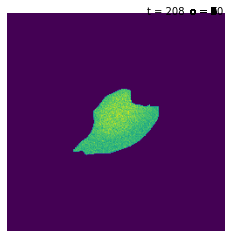

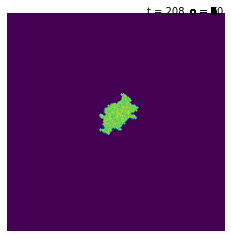

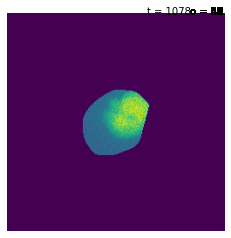

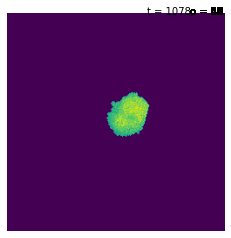

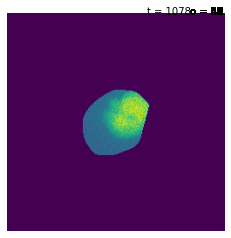

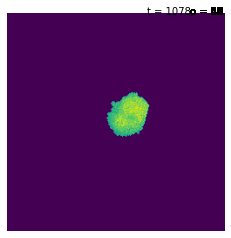

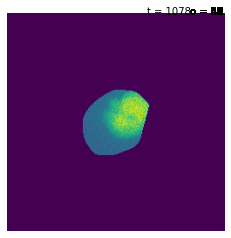

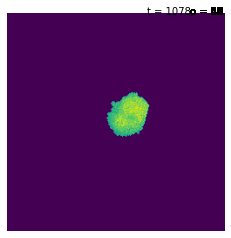

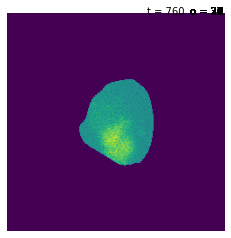

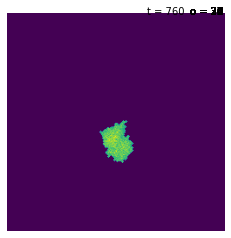

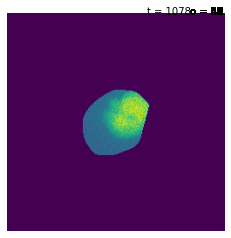

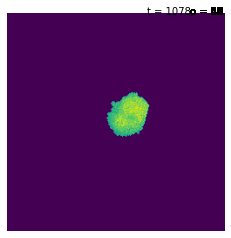

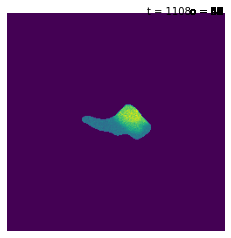

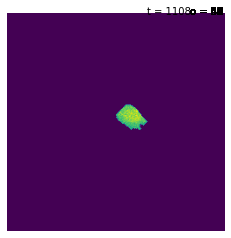

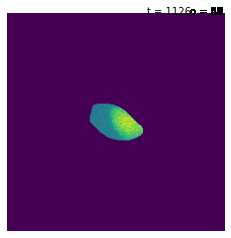

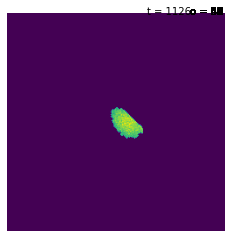

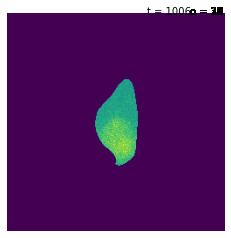

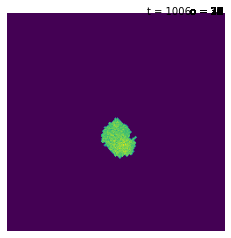

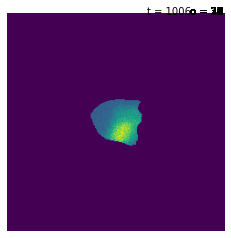

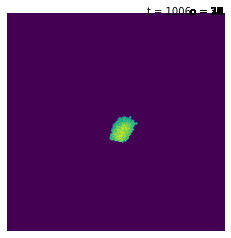

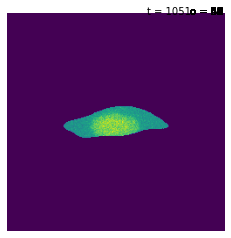

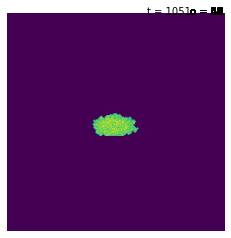

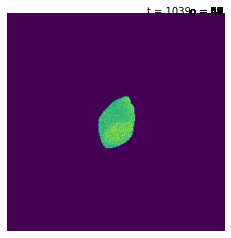

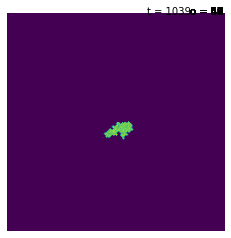

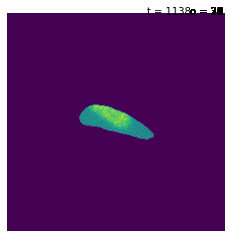

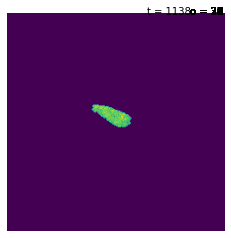

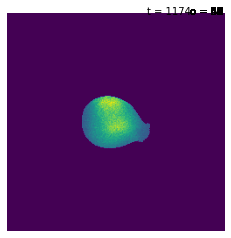

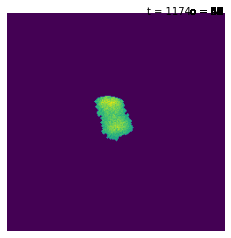

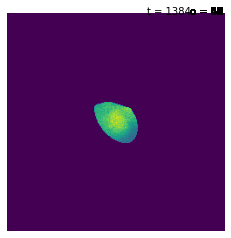

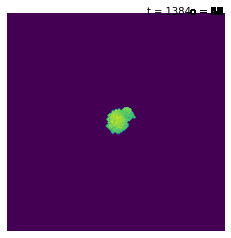

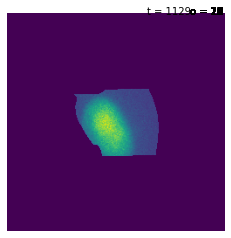

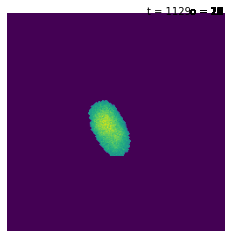

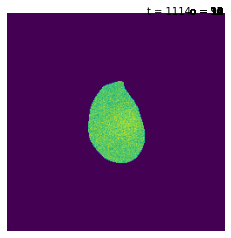

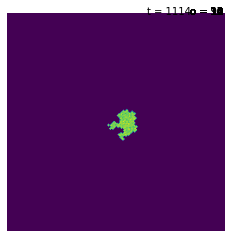

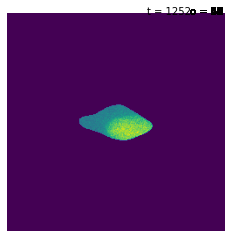

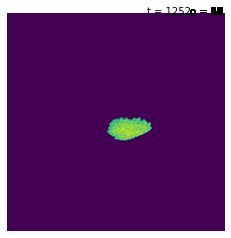

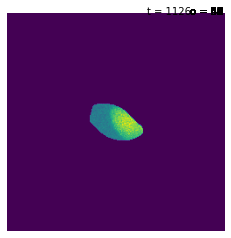

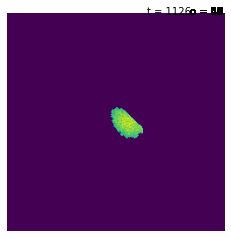

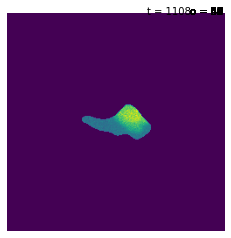

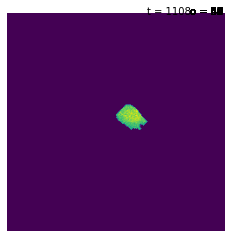

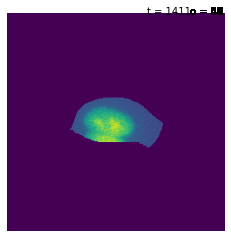

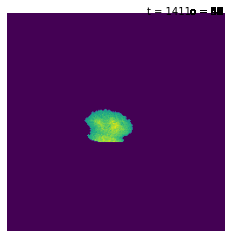

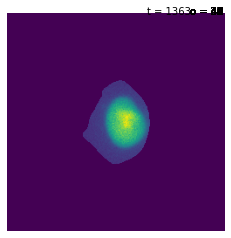

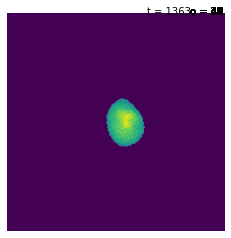

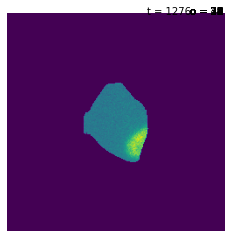

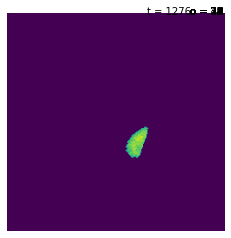

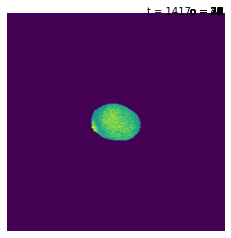

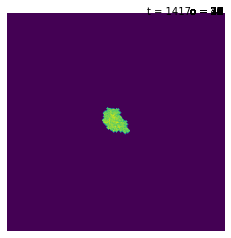

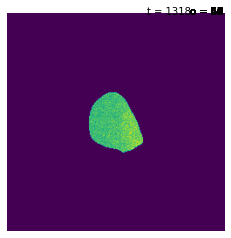

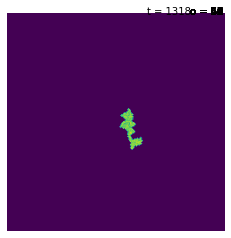

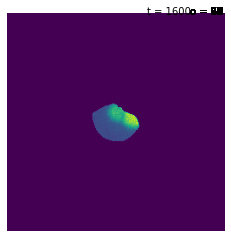

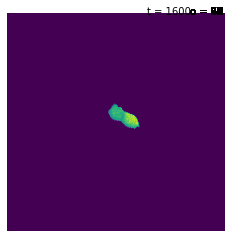

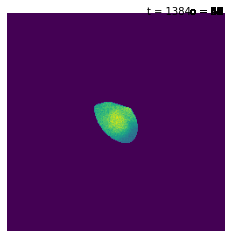

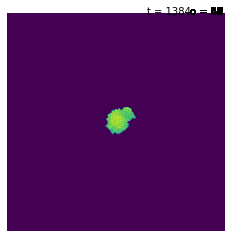

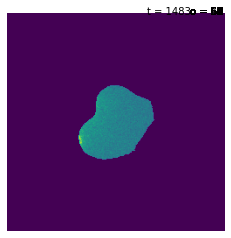

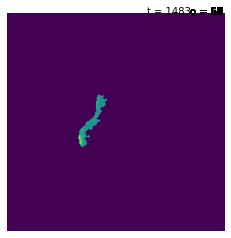

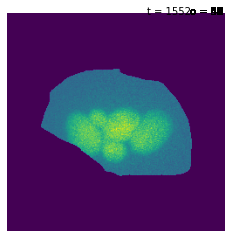

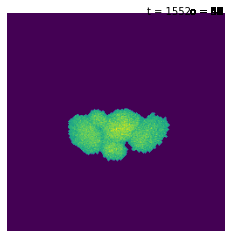

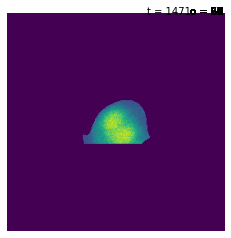

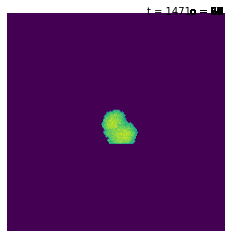

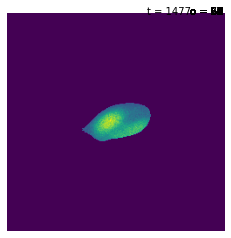

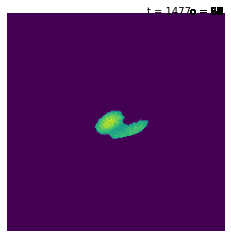

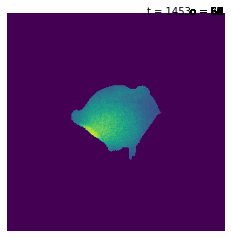

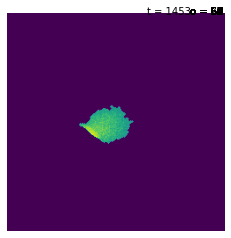

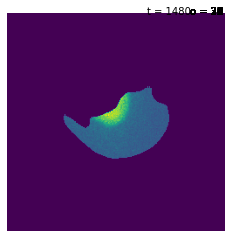

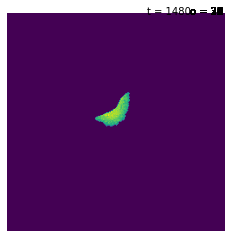

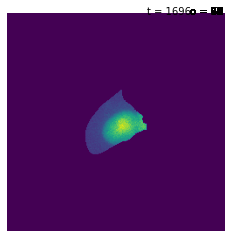

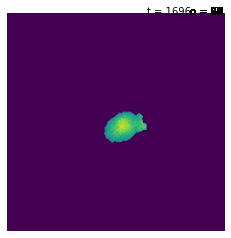

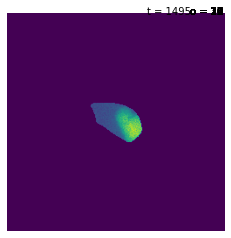

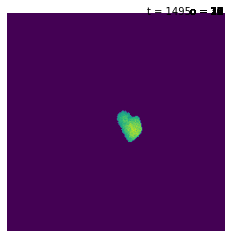

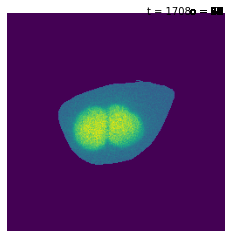

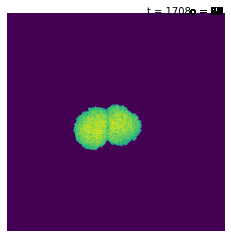

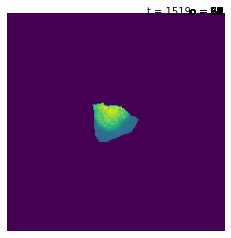

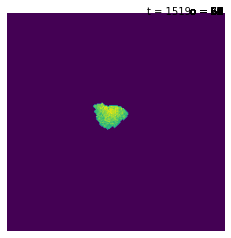

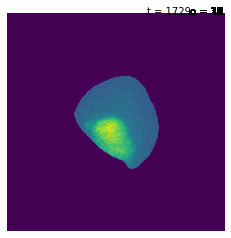

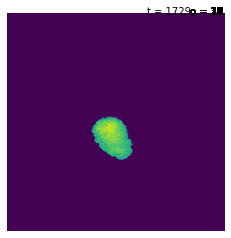

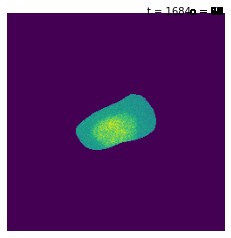

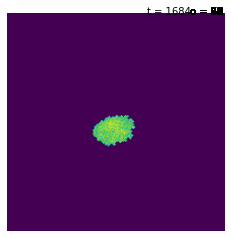

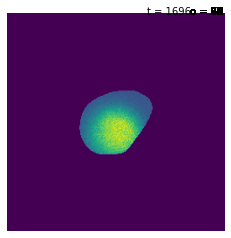

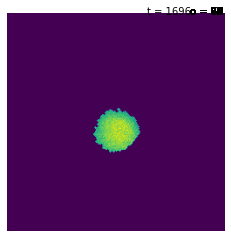

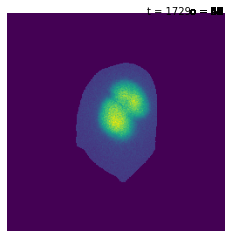

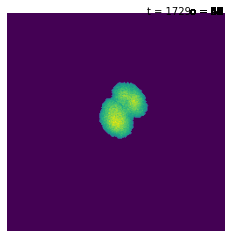

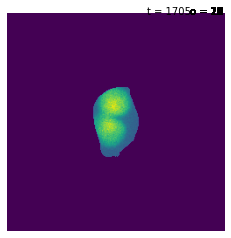

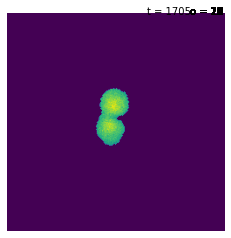

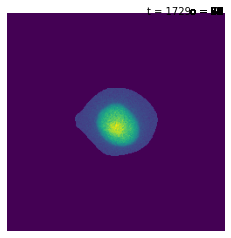

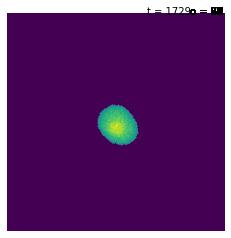

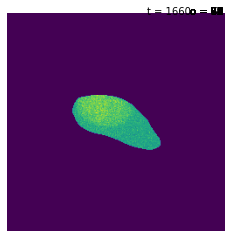

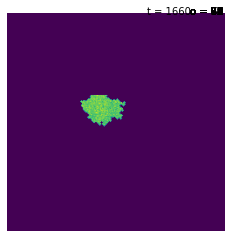

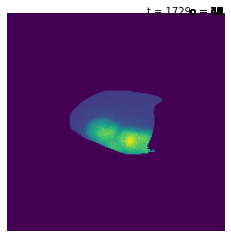

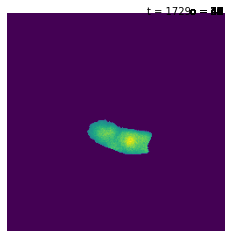

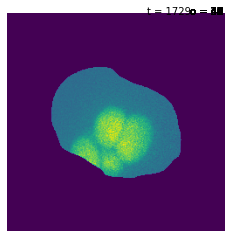

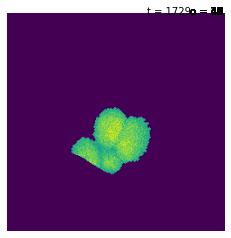

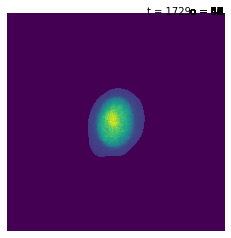

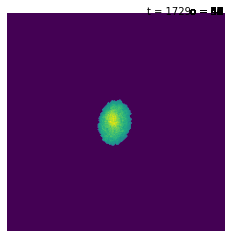

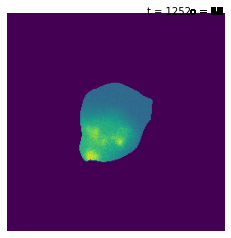

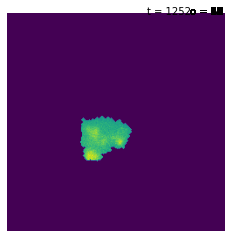

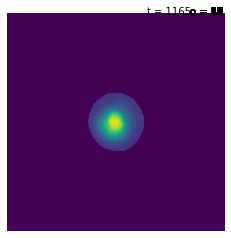

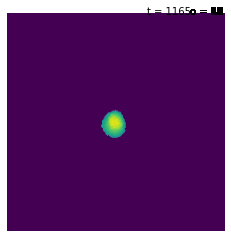

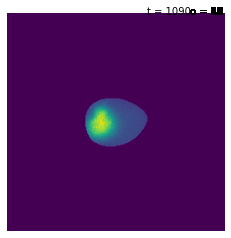

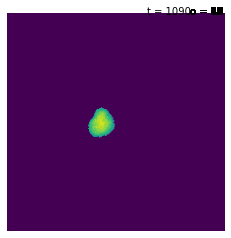

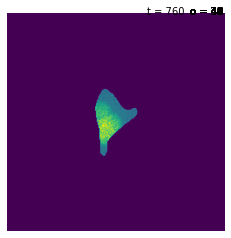

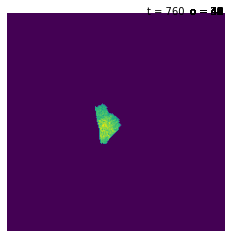

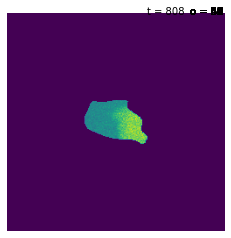

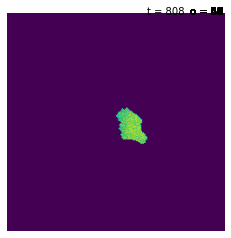

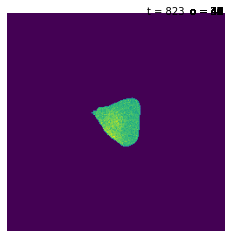

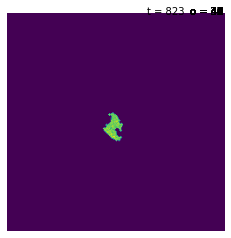

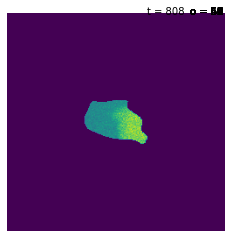

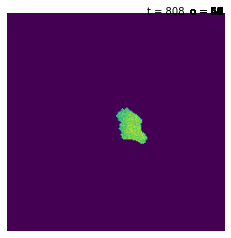

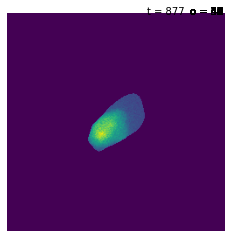

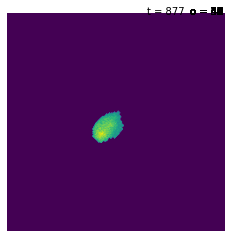

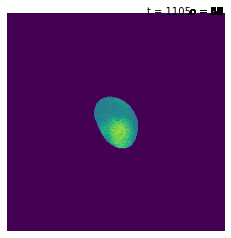

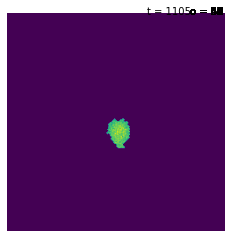

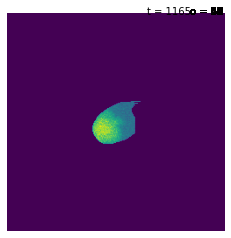

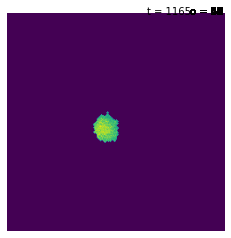

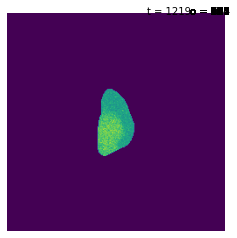

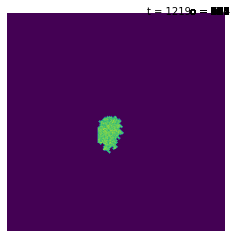

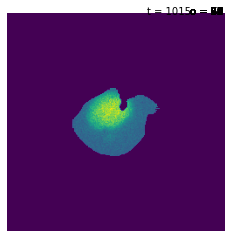

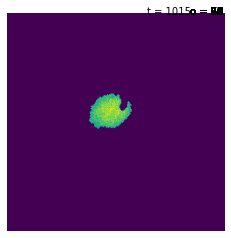

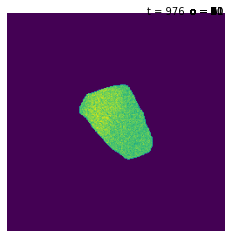

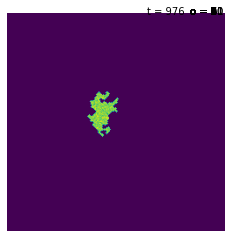

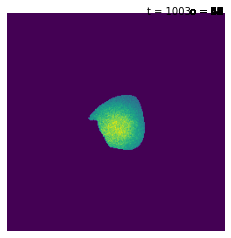

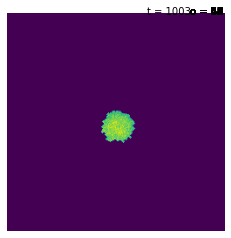

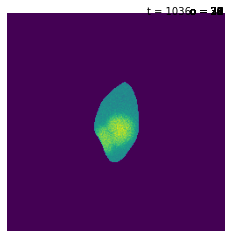

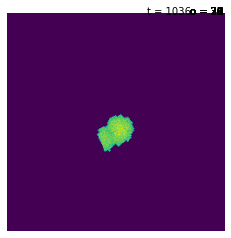

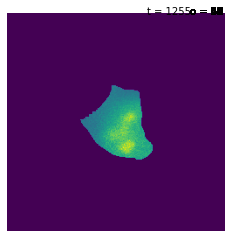

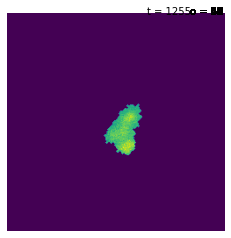

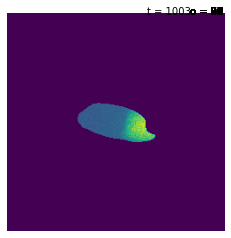

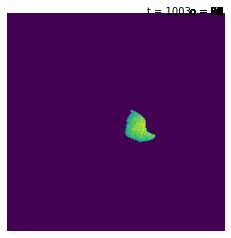

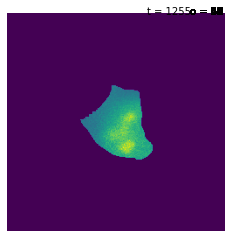

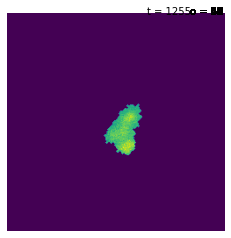

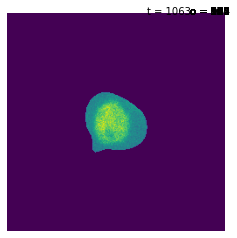

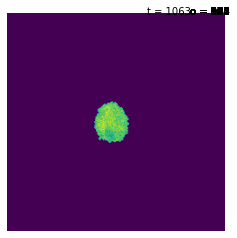

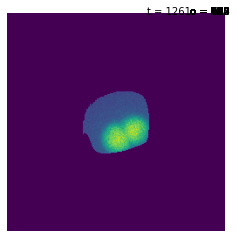

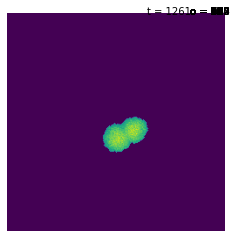

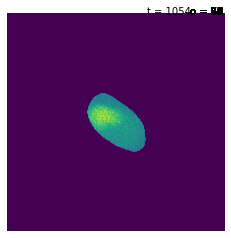

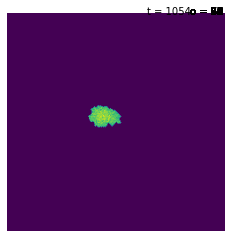

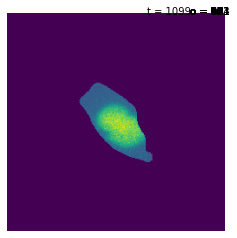

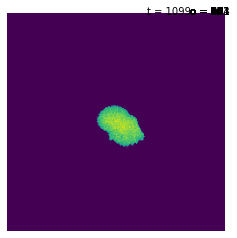

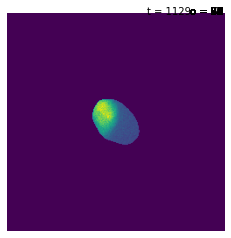

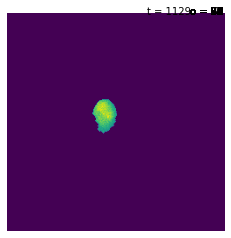

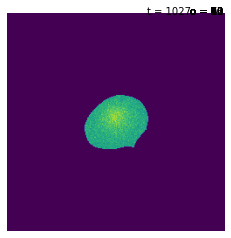

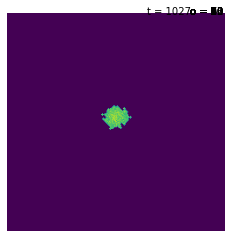

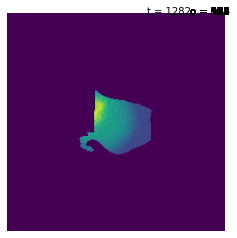

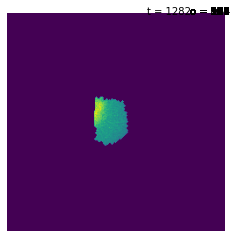

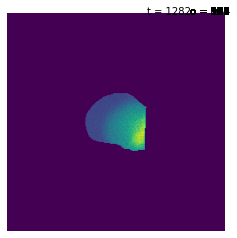

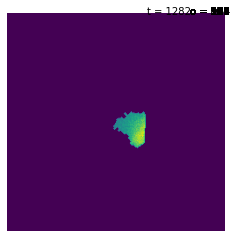

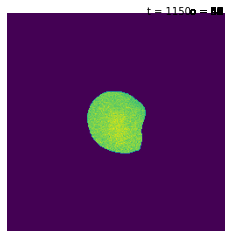

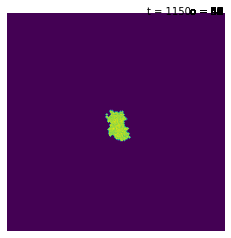

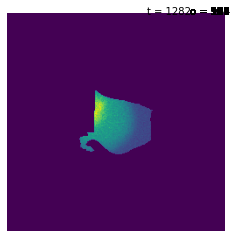

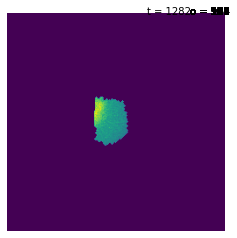

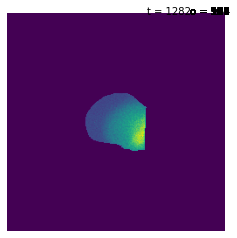

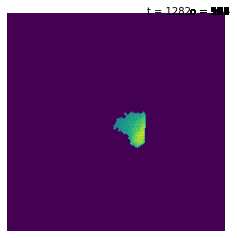

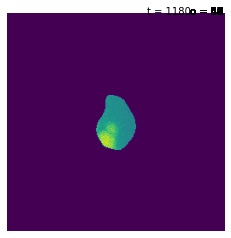

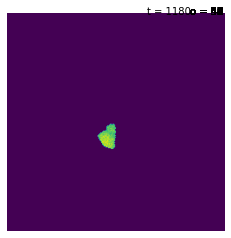

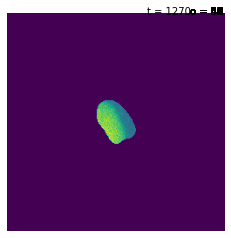

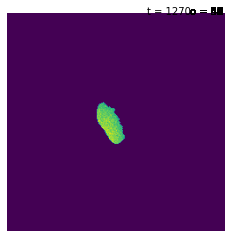

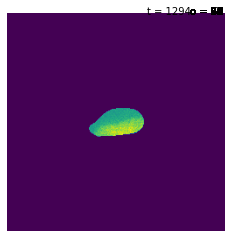

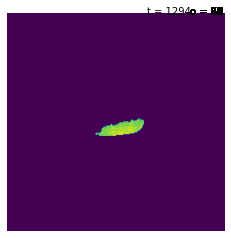

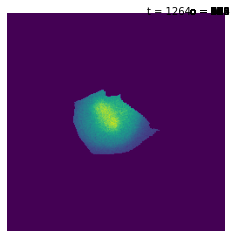

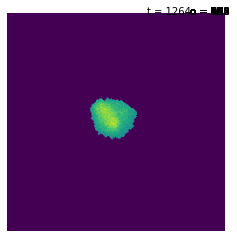

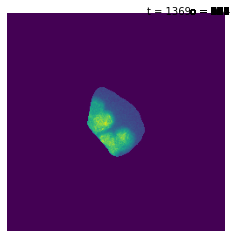

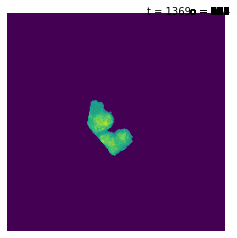

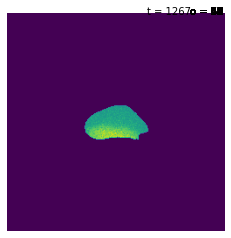

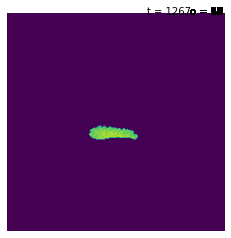

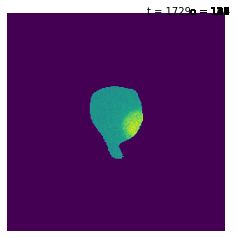

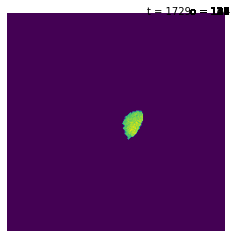

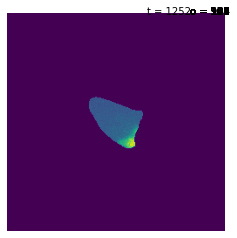

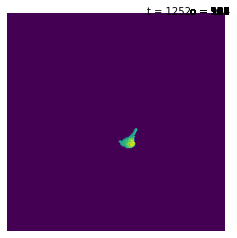

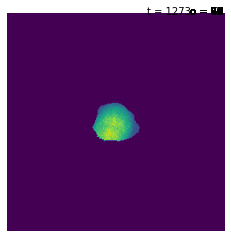

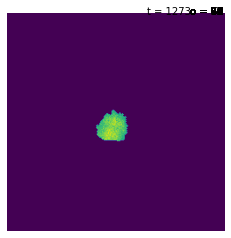

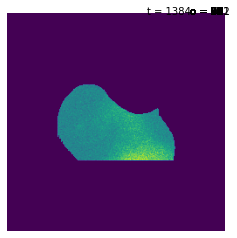

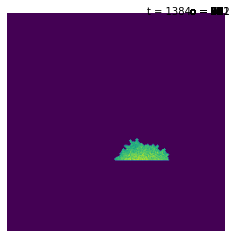

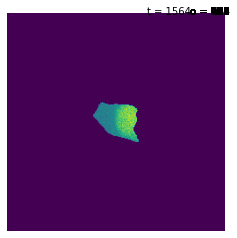

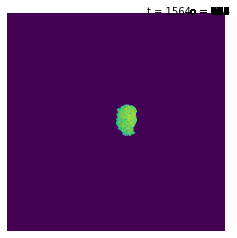

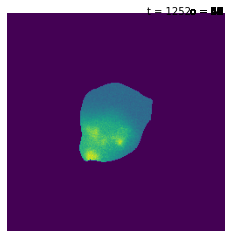

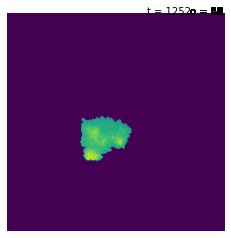

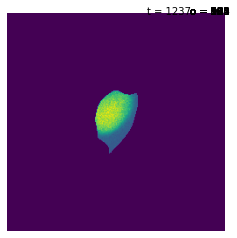

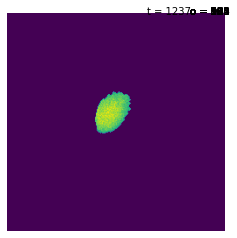

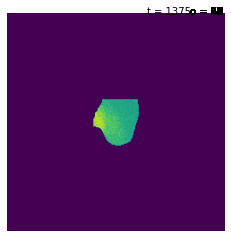

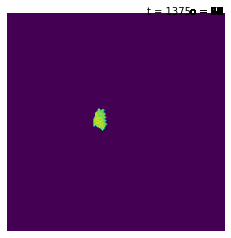

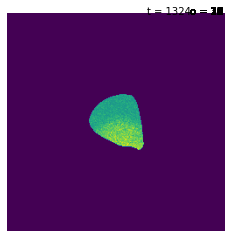

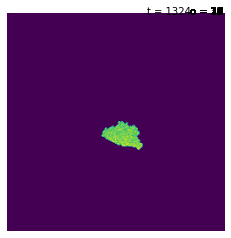

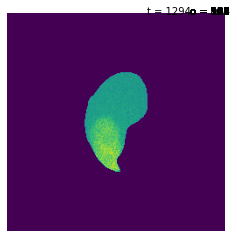

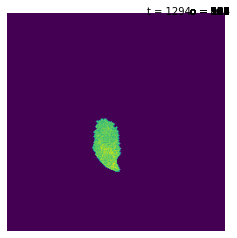

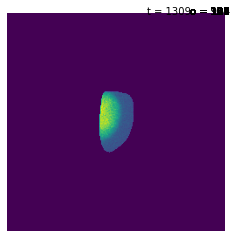

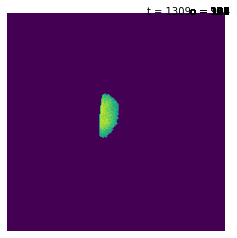

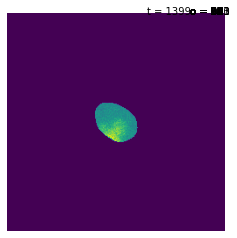

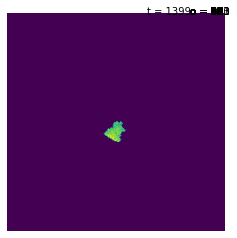

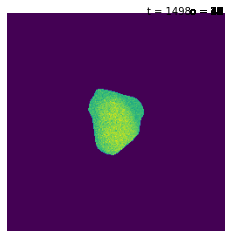

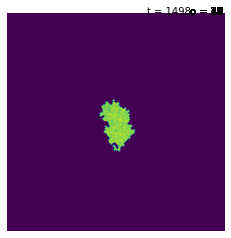

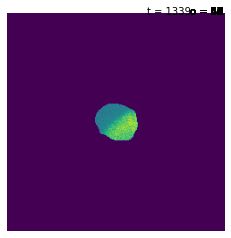

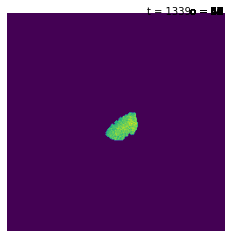

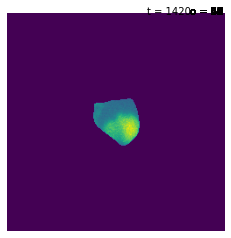

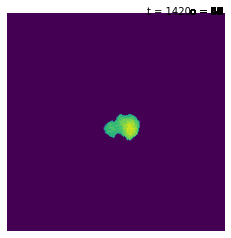

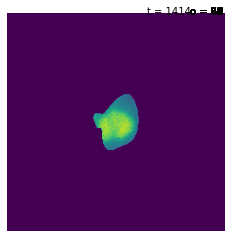

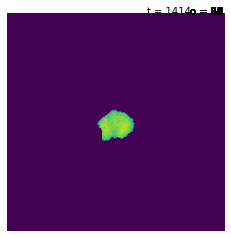

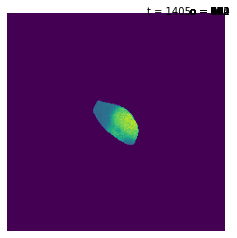

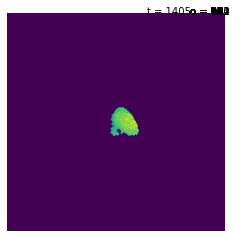

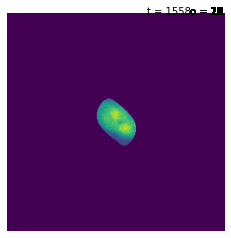

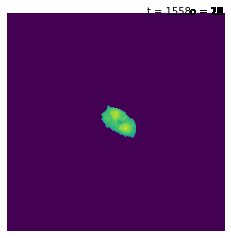

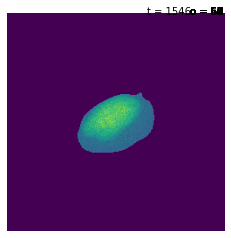

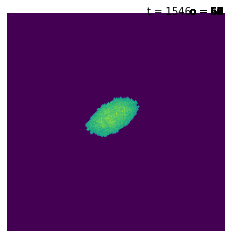

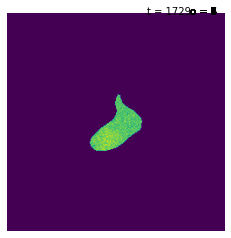

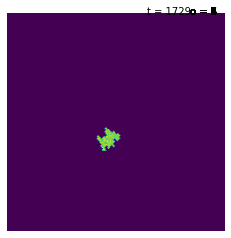

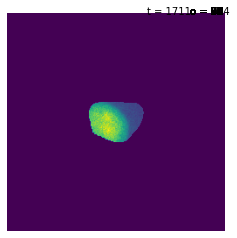

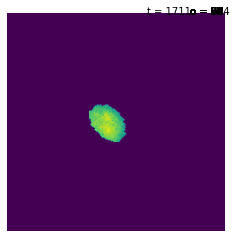

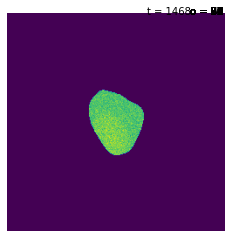

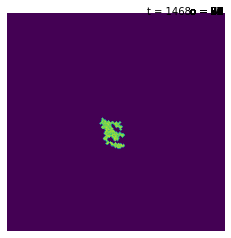

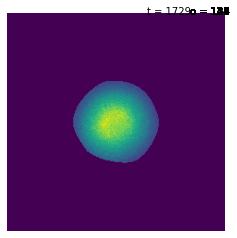

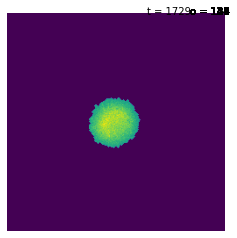

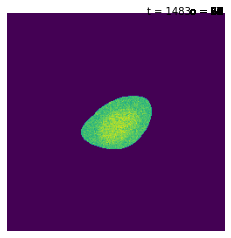

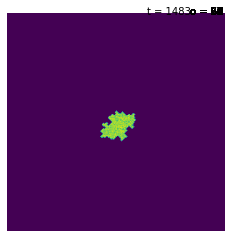

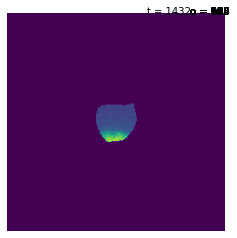

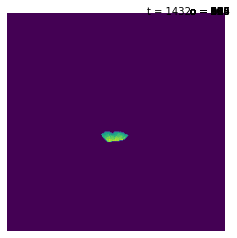

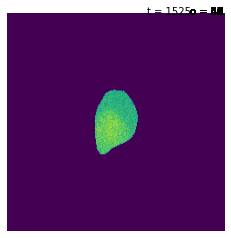

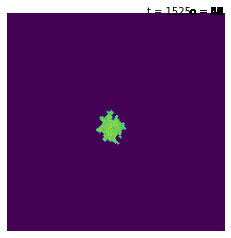

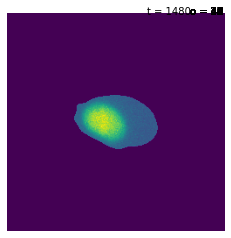

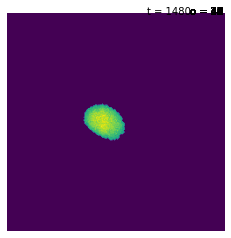

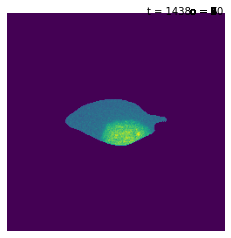

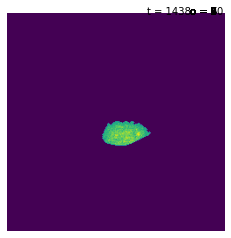

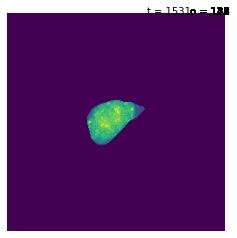

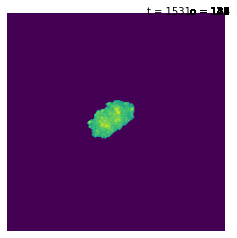

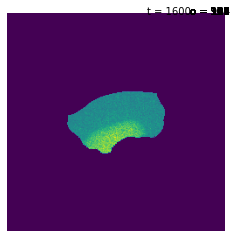

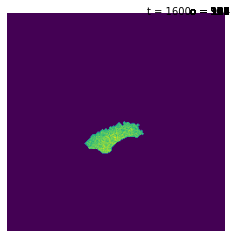

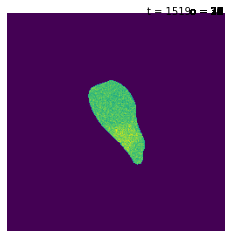

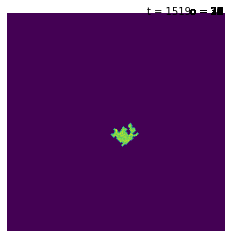

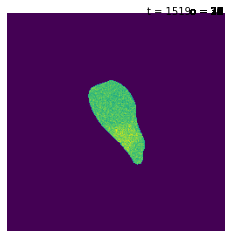

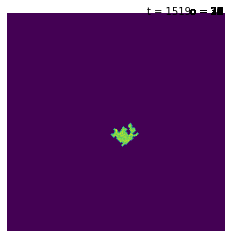

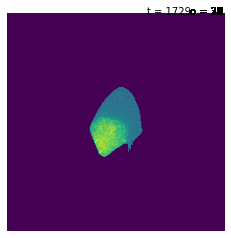

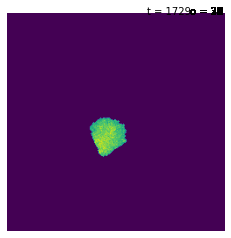

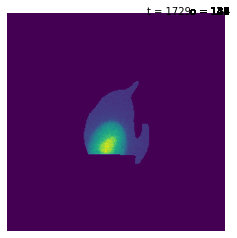

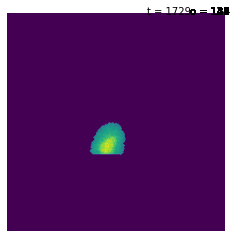

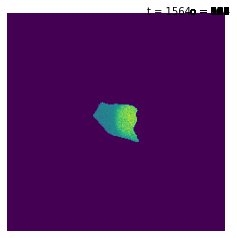

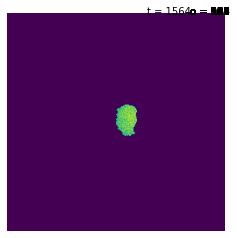

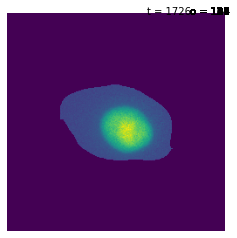

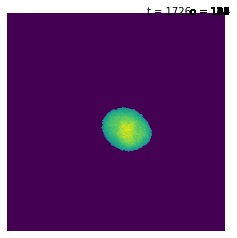

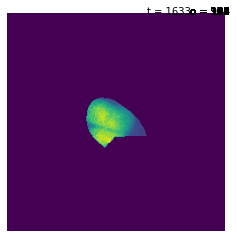

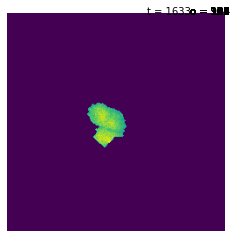

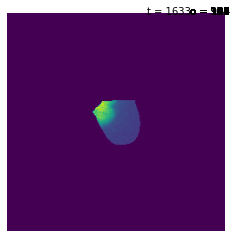

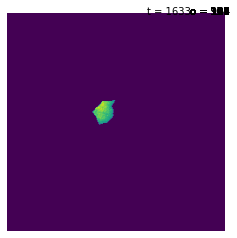

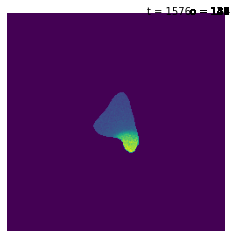

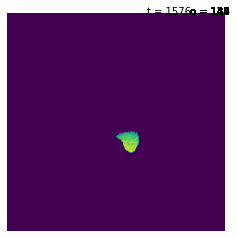

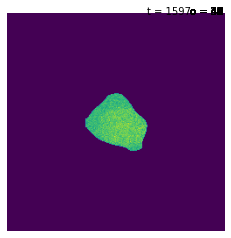

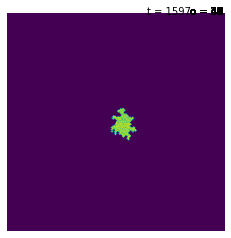

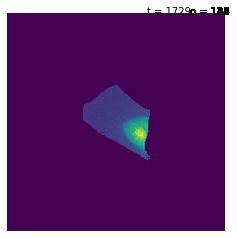

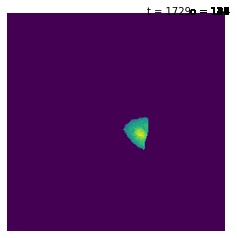

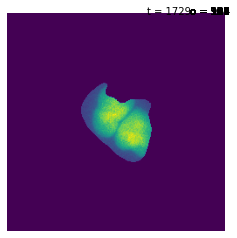

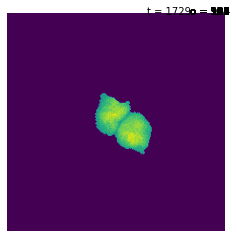

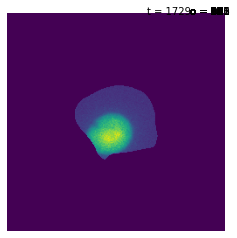

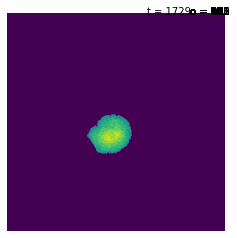

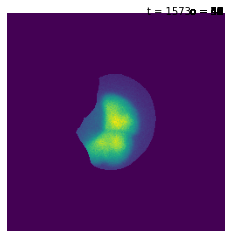

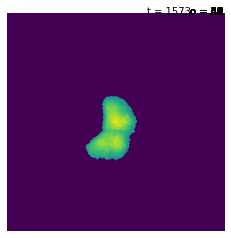

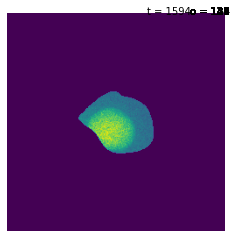

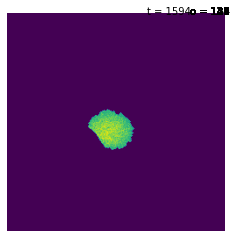

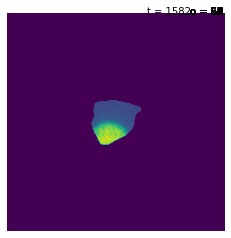

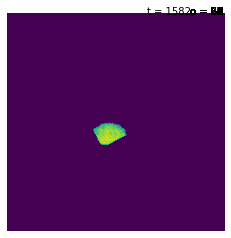

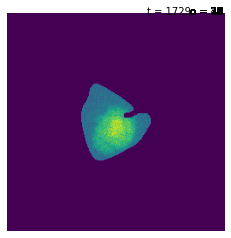

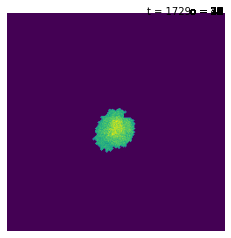

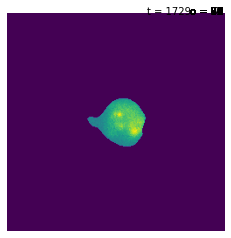

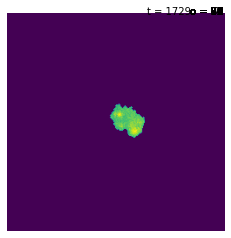

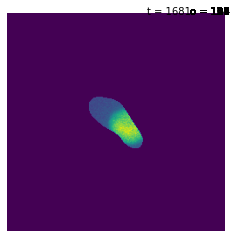

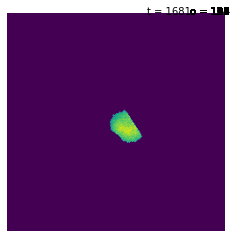

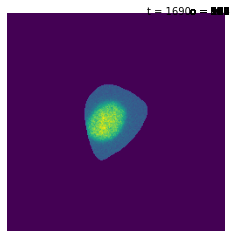

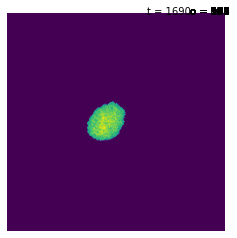

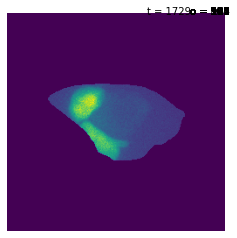

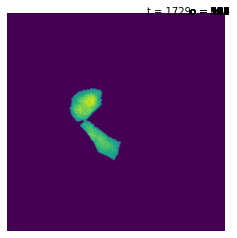

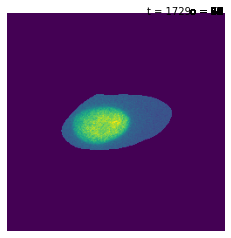

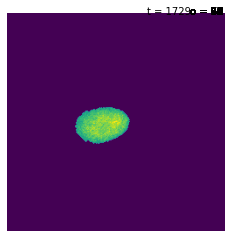

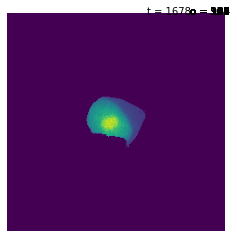

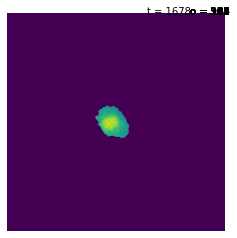

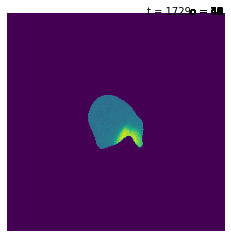

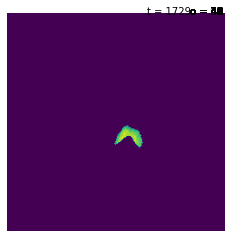

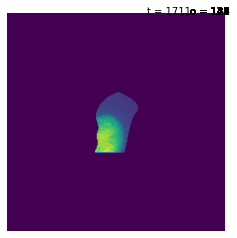

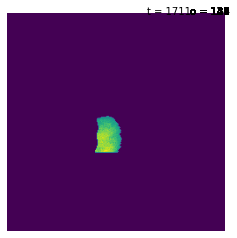

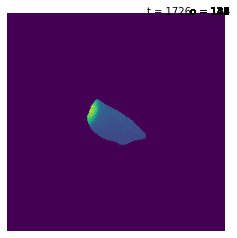

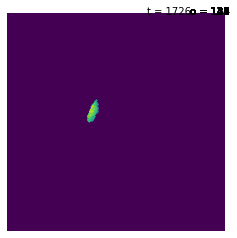

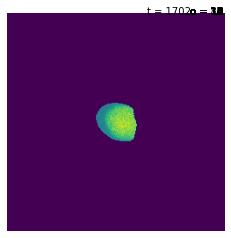

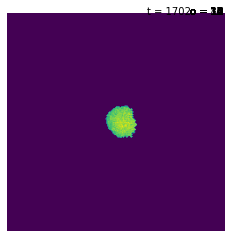

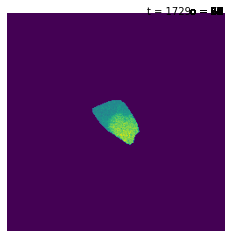

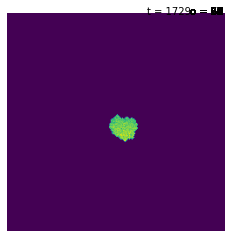

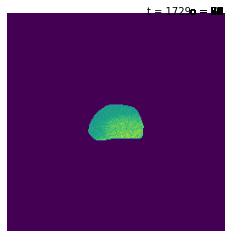

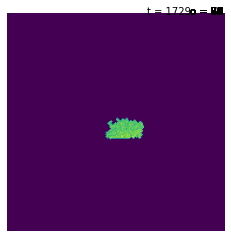

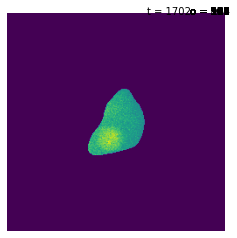

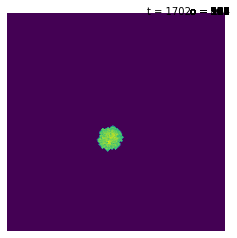

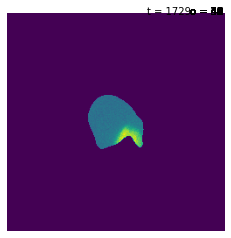

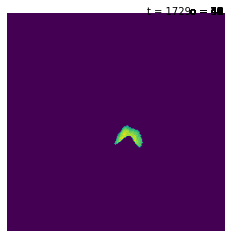

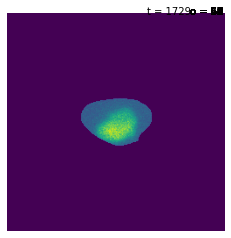

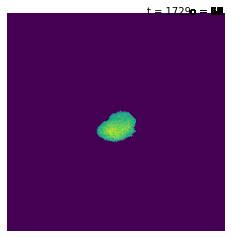

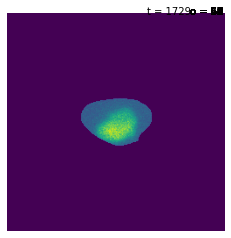

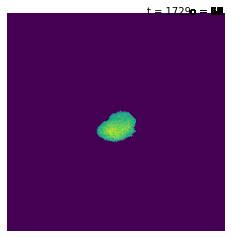

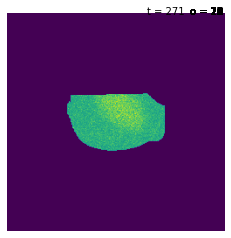

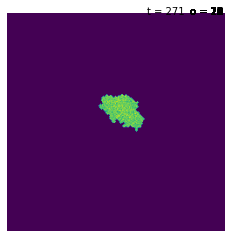

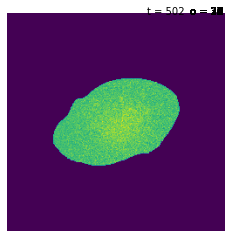

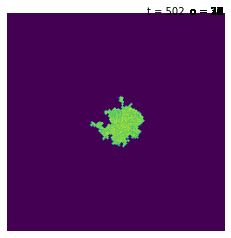

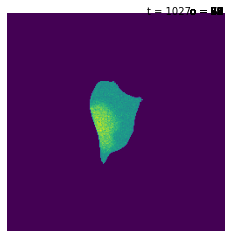

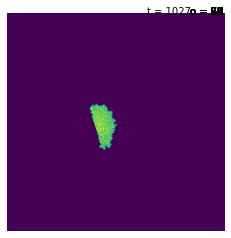

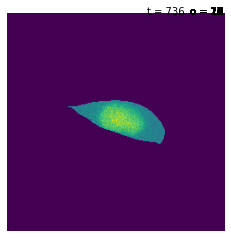

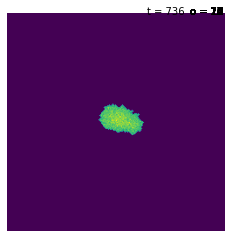

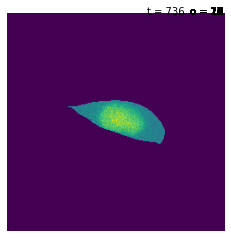

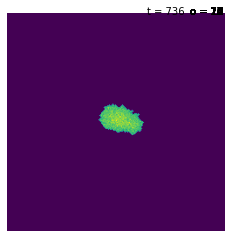

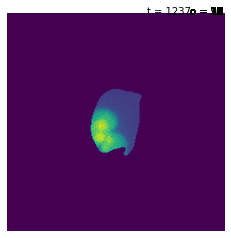

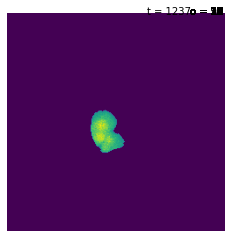

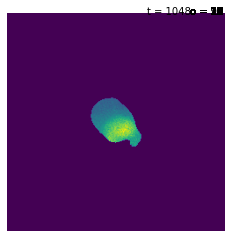

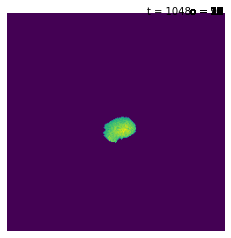

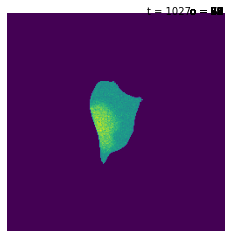

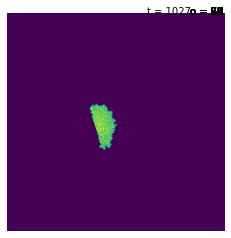

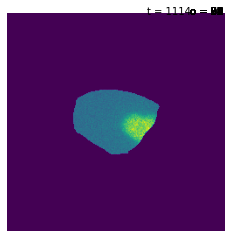

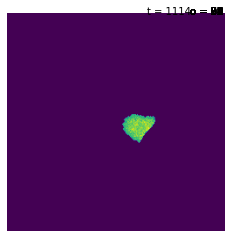

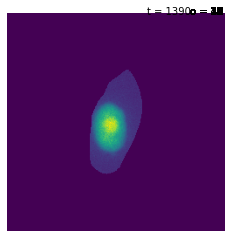

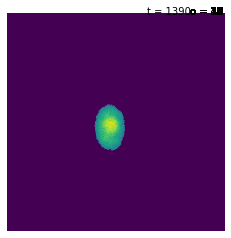

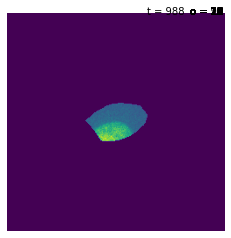

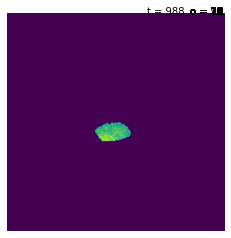

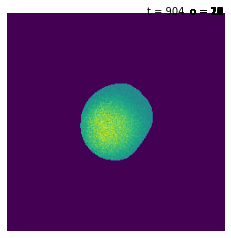

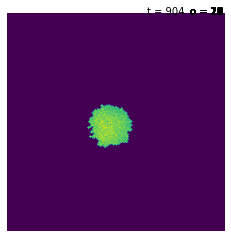

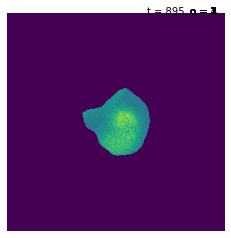

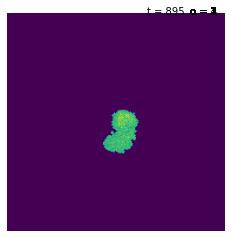

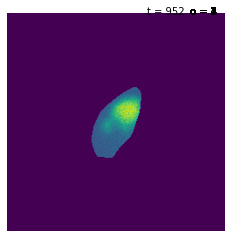

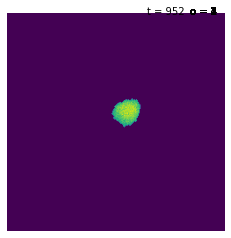

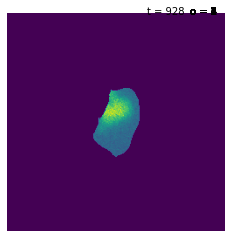

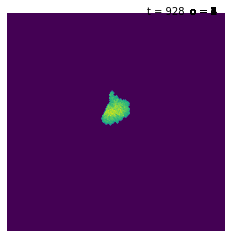

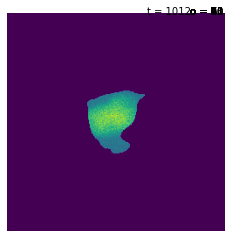

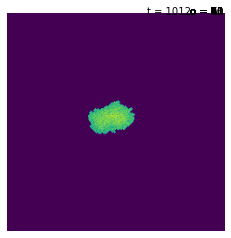

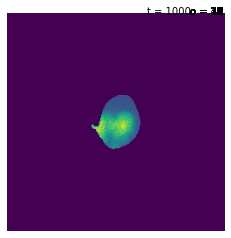

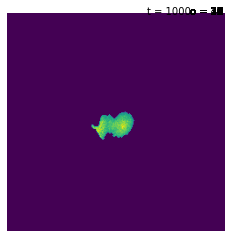

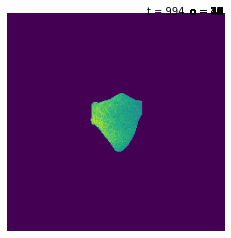

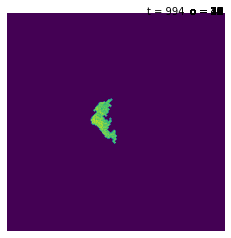

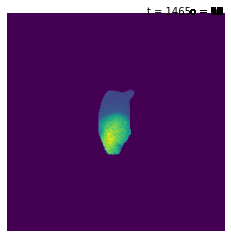

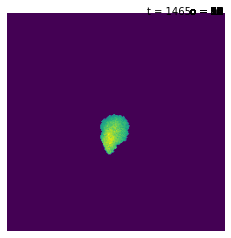

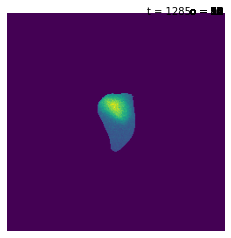

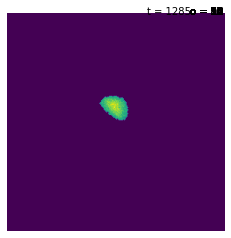

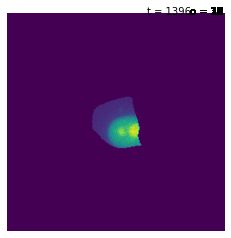

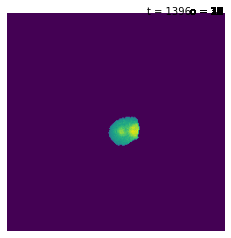

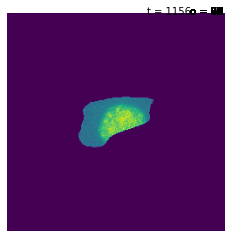

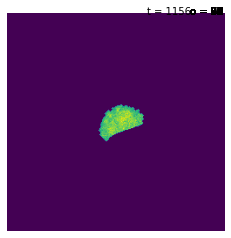

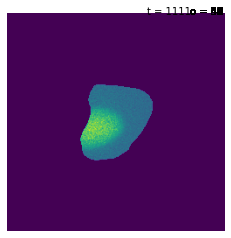

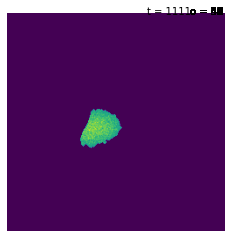

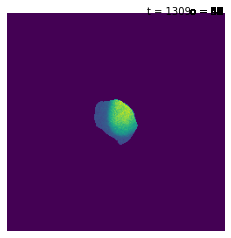

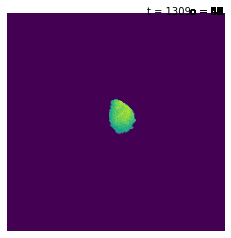

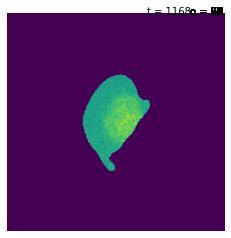

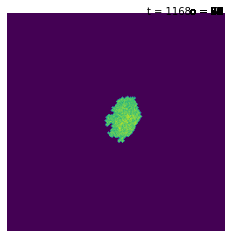

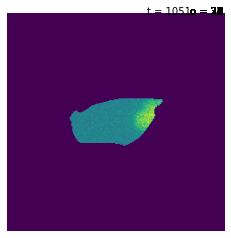

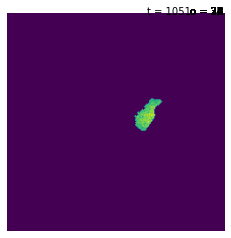

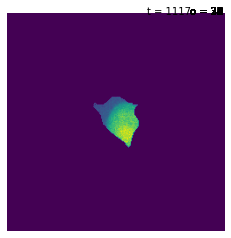

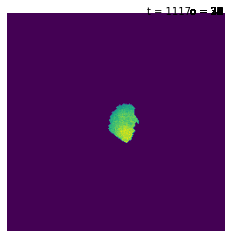

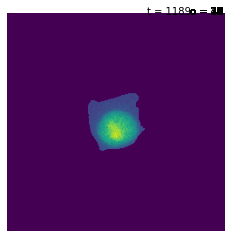

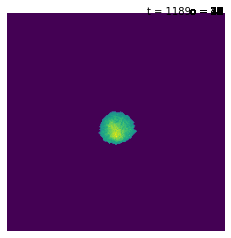

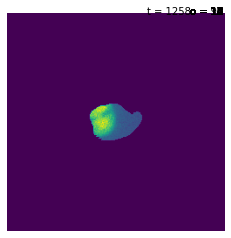

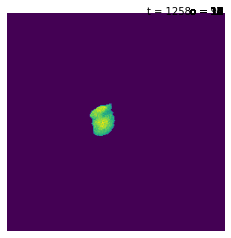

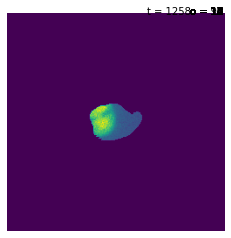

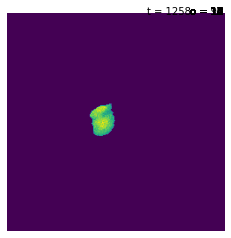

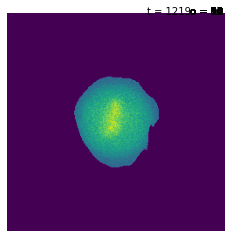

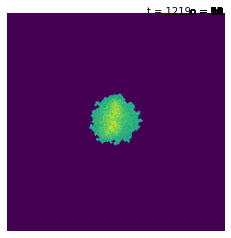

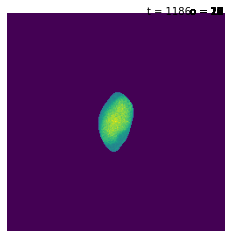

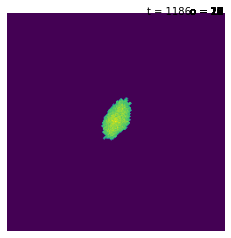

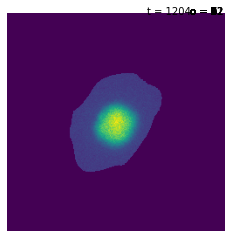

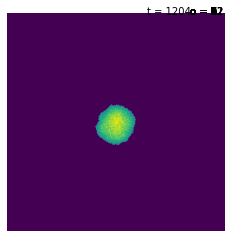

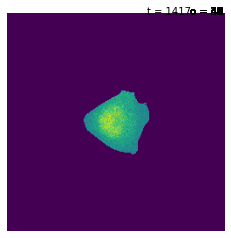

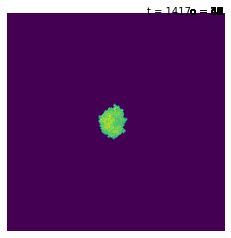

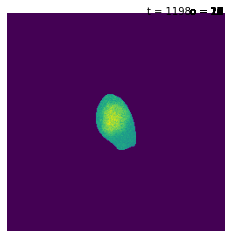

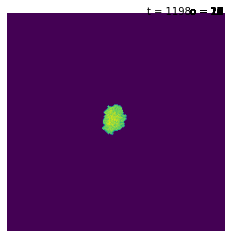

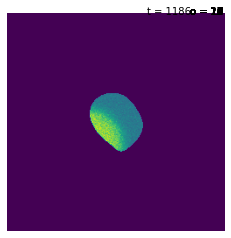

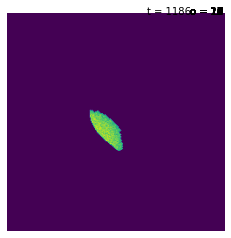

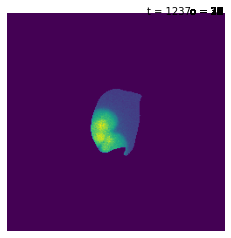

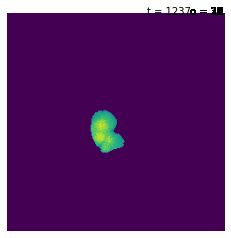

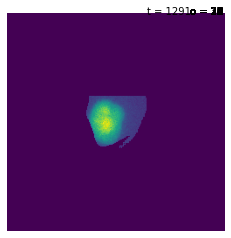

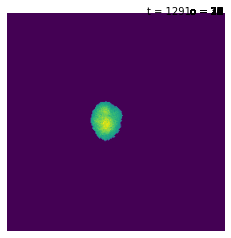

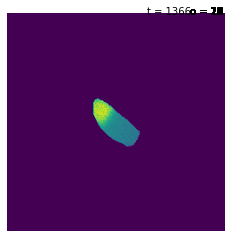

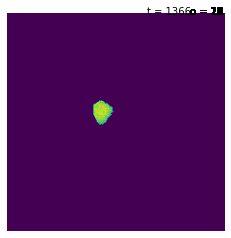

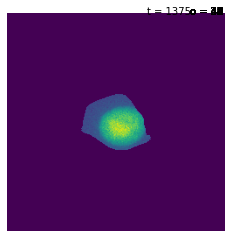

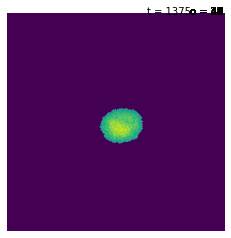

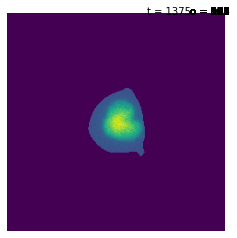

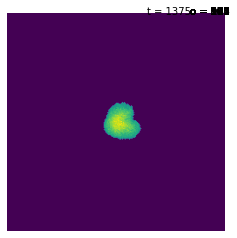

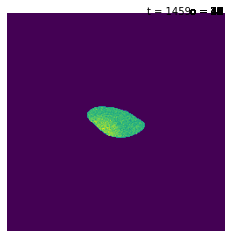

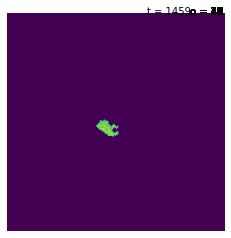

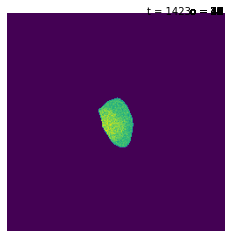

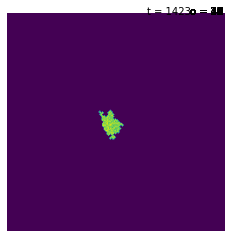

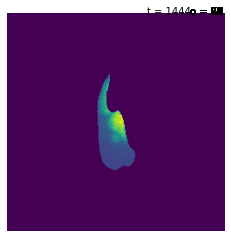

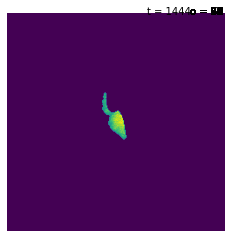

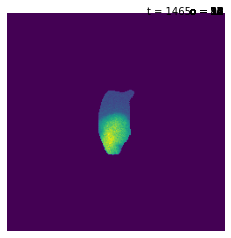

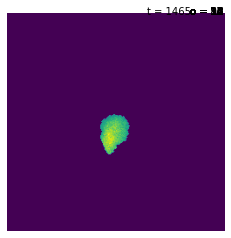

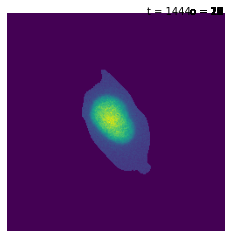

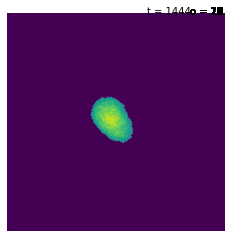

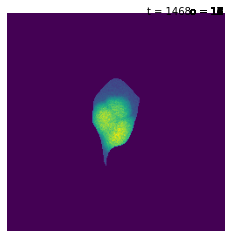

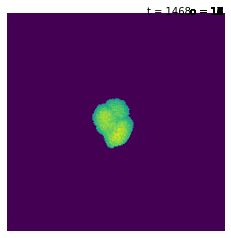

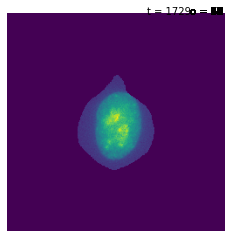

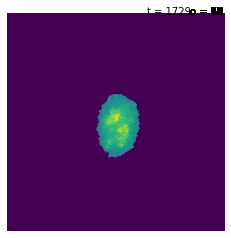

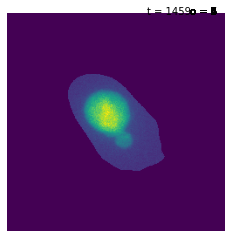

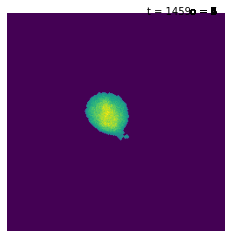

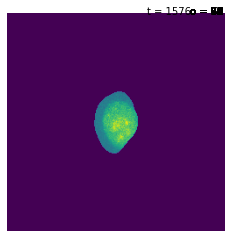

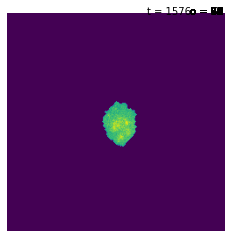

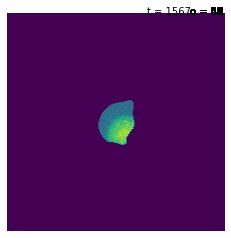

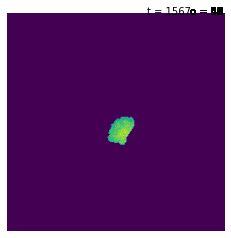

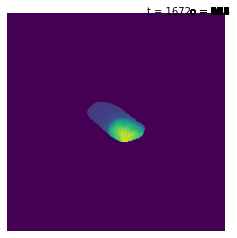

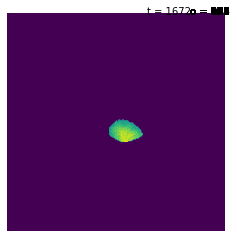

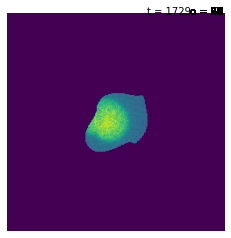

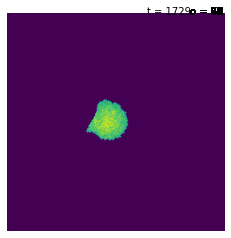

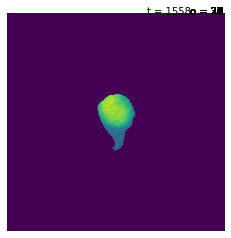

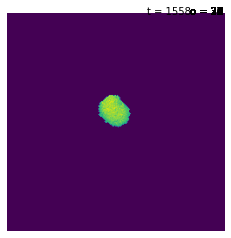

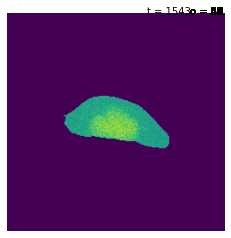

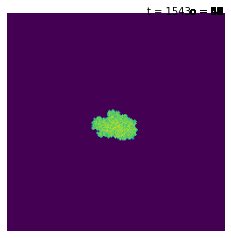

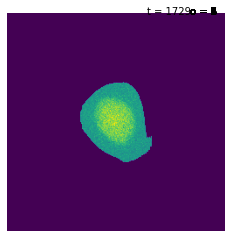

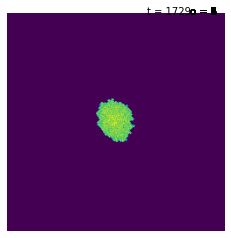

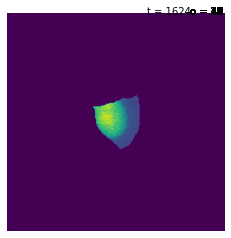

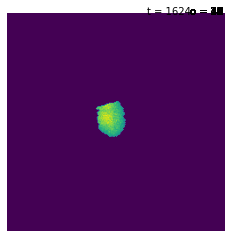

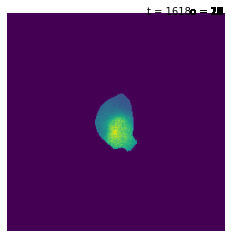

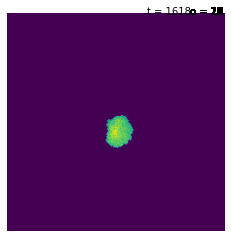

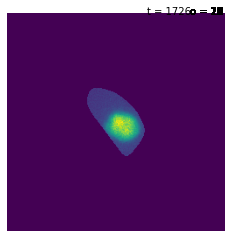

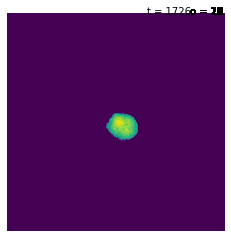

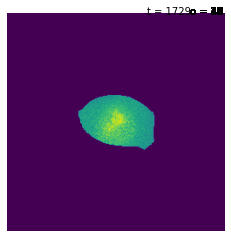

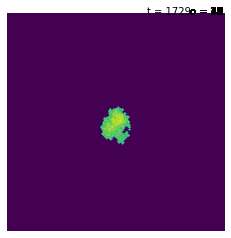

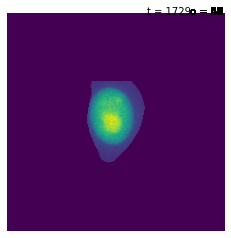

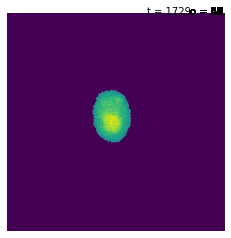

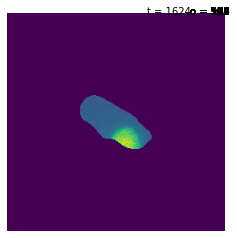

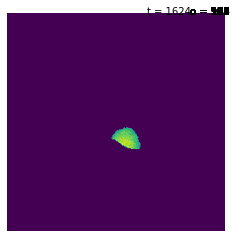

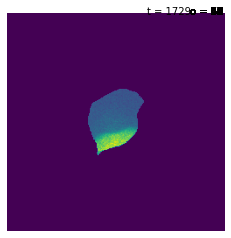

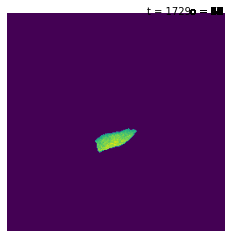

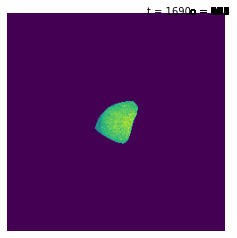

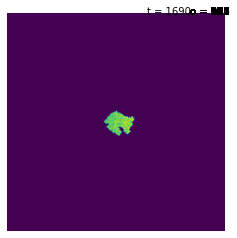

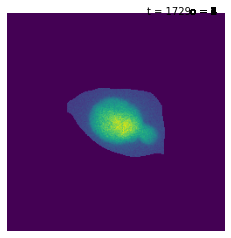

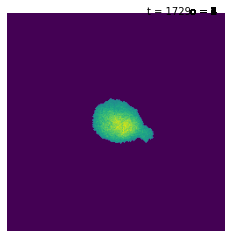

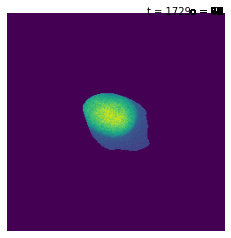

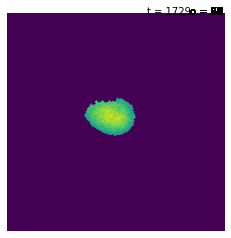

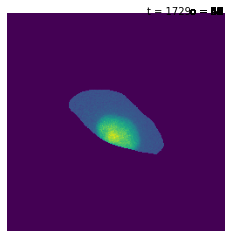

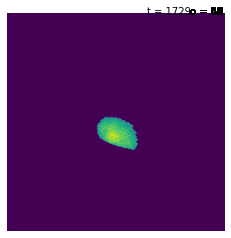

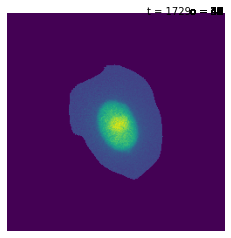

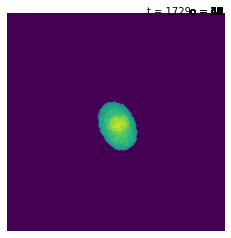

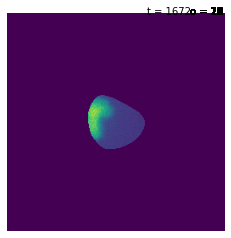

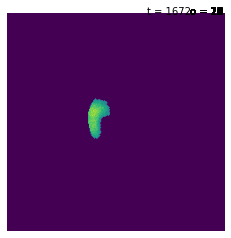

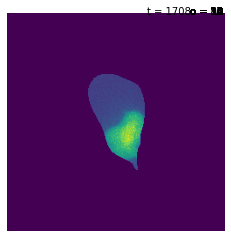

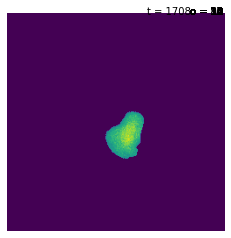

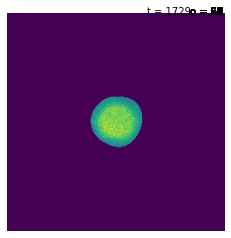

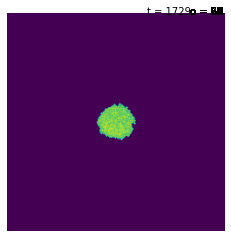

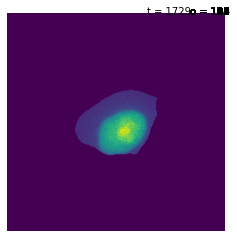

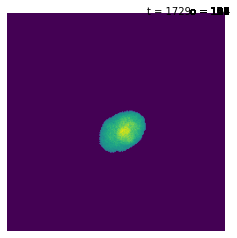

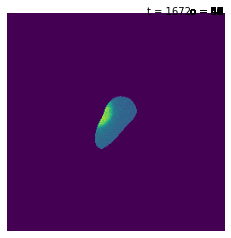

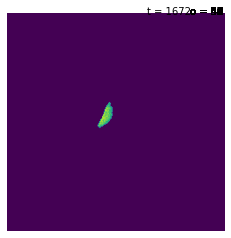

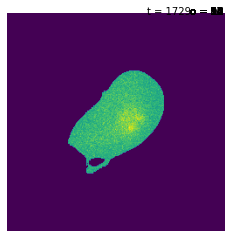

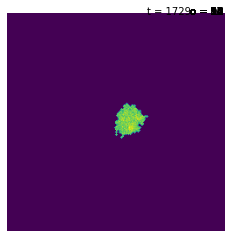

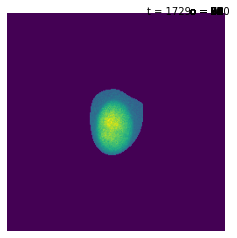

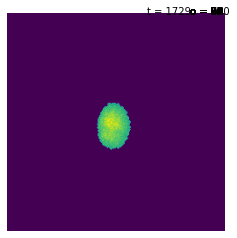

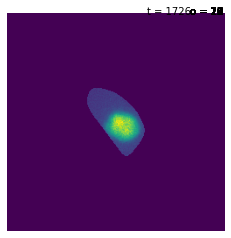

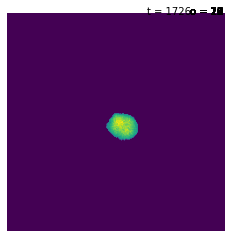

In [5]:
for posi in range(1,posi_end+1):
    posi_label = 'XY' + str(posi)
    print(posi_label)
    
    dir_path=output_path+posi_label+'/'
    fluor_img_path=main_path+'ori/'+posi_label+'_C2/'
    fluor_img_list=sorted(listdir(fluor_img_path))
    seg_path=output_path+posi_label+'/seg/'
    seg_list=sorted(listdir(seg_path))
        
    df=pd.read_csv(dir_path+'Per_Object_relink.csv')
    am_record=pd.read_csv(dir_path+'am_record.csv')
    traj_df=pd.read_csv(dir_path+'traj_object_num.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record.csv')
    with open (dir_path+'cells/'+'fluor_cells', 'rb') as fp:
        cells = pickle.load(fp)

    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values
    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]

    for traj_label in range(1,traj_quan+1):

        family_tree={}
        family_tree=find_offspring(df,mitosis_df,family_tree,traj_label=traj_label)
        print('family',family_tree)
        all_branches=list(list(parse(traj_label, family_tree)))
        print('all branch',all_branches)

        for branch in all_branches:   
            branch_end_label=branch[-1]
            branch_end_traj=traj_record[branch_end_label-1,:]
            branch_end_t=np.where(branch_end_traj!=-1)[0][-1]+1

            long_traj=-1*np.ones((time_span,))
            divide_points=[]
            traj_name=''
            for sub_label in branch:
                sub_traj=traj_record[sub_label-1,:]
                mask=sub_traj!=-1
                if (np.where(sub_traj!=-1)[0][-1]+1)!=branch_end_t:
                    divide_points.append(np.where(sub_traj!=-1)[0][-1]+1)
                long_traj[mask]=sub_traj[mask]
                traj_name=traj_name+str(sub_label)+'_' 
            
            daughter_flag=find_mother(mitosis_df,traj_label)
            mother_len = 0
            mother_len_thres = 12
            if daughter_flag==1:
                mother_label=find_mother_label(mitosis_df,traj_label)
                mother_traj=traj_record[mother_label-1,:]
                mother_start_t=np.where(mother_traj!=-1)[0][0]+1
                mother_end_t=np.where(mother_traj!=-1)[0][-1]+1
                mother_len=mother_end_t-mother_start_t
                    
                if mother_len >= mother_len_thres:
                    long_traj[mother_end_t-mother_len_thres:mother_end_t]=\
                        mother_traj[mother_end_t-mother_len_thres:mother_end_t]
                else:
                    mother_mask=mother_traj!=-1
                    long_traj[mother_mask]=mother_traj[mother_mask]
            traj_start_t=np.where(long_traj!=-1)[0][0]+1
                           
            whole_branch=long_traj[traj_start_t-1:branch_end_t]
            long_traj_loss_ratio=whole_branch[whole_branch==-1].shape[0]*1.0/whole_branch.shape[0]
            
            if long_traj_loss_ratio<loss_ratio_thres and (branch_end_t-traj_start_t)>=traj_len_thres:

                traj_feature,traj_contour,\
                    traj_cord,traj_seri,traj_am_flag,\
                    traj_vim_feature_values,traj_vim_pca_cord,\
                    traj_pcna_feature_values,traj_pcna_pca_cord=generate_fluor_long_traj(
                    df,cells,am_record,\
                    traj_df,long_traj,\
                    ['vimentin','pcna'],feature_list,fluor_feature_name)
                if len(traj_seri) >= 25:
                    traj_sct=fluor_single_cell_traj(traj_seri,traj_contour)
                    traj_sct.set_traj_feature(traj_feature)
                    traj_sct.set_traj_cord(traj_cord)
                    traj_sct.set_traj_divide_points(np.array(divide_points))
                    traj_sct.set_traj_am_flag(traj_am_flag)

                    traj_sct.set_traj_fluor_features('vimentin',feature_list,traj_vim_feature_values)
                    traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[0],traj_vim_pca_cord)

                    traj_sct.set_traj_fluor_features('pcna',feature_list,traj_pcna_feature_values)
                    traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[1],traj_pcna_pca_cord)

                    if branch_end_label==traj_label:
                        with open(sct_path+'fluor_sct_'+posi_label+'_'+traj_name+'long_traj', 'wb') as fp:
                            pickle.dump(traj_sct, fp)
                            
                        board_size=250

                        fig=plt.figure()
                        ax = fig.add_subplot(111)
                        ims=[]
                        for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:
                            img_num=img_num.astype(np.int)
                            obj_num=obj_num.astype(np.int)
                            if obj_num!=-1:
                                img=imread(fluor_img_path+fluor_img_list[img_num-1])
                                seg_img=imread(seg_path+seg_list[img_num-1])
                                crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
                                x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
                                x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                cell_on_board=np.zeros((board_size,board_size))
                                cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell
                                plt.axis('off')
                                im=plt.imshow(cell_on_board,animated=True)
                                t = ax.annotate('t = ' + str(img_num),(160,1))
                                o = ax.annotate('o = ' + str(obj_num),(210,1))
                                ims.append([im,t])

                            ani = animation.ArtistAnimation(fig, ims)
                            ani = animation.ArtistAnimation(fig, ims)
                            Writer = animation.writers['ffmpeg']
                            writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                        ani.save(cell_ani_path+'pcna_sct_'+posi_label+'_'+traj_name+'long_traj.mp4',writer)

                        fig=plt.figure()
                        ax = fig.add_subplot(111)
                        ims=[]
                        for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:

                            img_num=img_num.astype(np.int)
                            obj_num=obj_num.astype(np.int)

                            img=imread(fluor_img_path+fluor_img_list[img_num-1])
                            seg=imread(seg_path+seg_list[img_num-1])

                            if obj_num!=-1:

                                rps=regionprops(seg)
                                candi_r=[r for r in rps if r.label==obj_num][0]
                                candi_box=candi_r.bbox

                                cell_mask = (seg == obj_num)
                                region_cell_mask = cell_mask[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                crop_img = img[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                cell_img = (img*cell_mask)[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]

                                nuc_mask=cell_img>otsu(cell_img,selem=disk(max(cell_img.shape)/2), mask=cell_img>0)
                                nuc_mask=remove_small_objects(opening(nuc_mask),100)
                                nuc_mask=closing(nuc_mask)
                                nuc_mask=remove_small_holes(nuc_mask,100)

                                nuc_img=cell_img*nuc_mask

                                x_c,y_c=nuc_img.shape[0]//2,nuc_img.shape[1]//2
                                x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                cell_on_board=np.zeros((board_size,board_size))
                                cell_on_board[x_l:x_l+nuc_img.shape[0],y_l:y_l+nuc_img.shape[1]]=nuc_img
                                plt.axis('off')
                                im=plt.imshow(cell_on_board,animated=True)
                                t = ax.annotate('t = ' + str(img_num),(160,1))
                                o = ax.annotate('o = ' + str(obj_num),(210,1))
                                ims.append([im,t])

        #                 ani = animation.ArtistAnimation(fig, ims)
                        ani = animation.ArtistAnimation(fig, ims)
                        Writer = animation.writers['ffmpeg']
                        writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                        ani.save(cell_nuc_ani_path+'pcna_sct_'+posi_label+'_'+traj_name+'long_traj.mp4',writer)
                        
                    else:
                        with open(sct_path+'indirect_fluor_sct_'+posi_label+'_'+traj_name+'long_traj', 'wb') as fp:
                            pickle.dump(traj_sct, fp)


                        board_size=250

                        fig=plt.figure()
                        ax = fig.add_subplot(111)
                        ims=[]
                        for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:
                            img_num=img_num.astype(np.int)
                            obj_num=obj_num.astype(np.int)
                            if obj_num!=-1:
                                img=imread(fluor_img_path+fluor_img_list[img_num-1])
                                seg_img=imread(seg_path+seg_list[img_num-1])
                                crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
                                x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
                                x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                cell_on_board=np.zeros((board_size,board_size))
                                cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell
                                plt.axis('off')
                                im=plt.imshow(cell_on_board,animated=True)
                                t = ax.annotate('t = ' + str(img_num),(160,1))
                                o = ax.annotate('o = ' + str(obj_num),(210,1))
                                ims.append([im,t,o])

                            ani = animation.ArtistAnimation(fig, ims)
                            ani = animation.ArtistAnimation(fig, ims)
                            Writer = animation.writers['ffmpeg']
                            writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                        ani.save(cell_ani_path+'indirect_pcna_sct_'+posi_label+'_'+traj_name+'long_traj.mp4',writer)

                        fig=plt.figure()
                        ax = fig.add_subplot(111)
                        ims=[]
                        for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:

                            img_num=img_num.astype(np.int)
                            obj_num=obj_num.astype(np.int)

                            img=imread(fluor_img_path+fluor_img_list[img_num-1])
                            seg=imread(seg_path+seg_list[img_num-1])

                            if obj_num!=-1:

                                rps=regionprops(seg)
                                candi_r=[r for r in rps if r.label==obj_num][0]
                                candi_box=candi_r.bbox

                                cell_mask = (seg == obj_num)
                                region_cell_mask = cell_mask[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                crop_img = img[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                cell_img = (img*cell_mask)[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]

                                nuc_mask=cell_img>otsu(cell_img,selem=disk(max(cell_img.shape)/2), mask=cell_img>0)
                                nuc_mask=remove_small_objects(opening(nuc_mask),100)
                                nuc_mask=closing(nuc_mask)
                                nuc_mask=remove_small_holes(nuc_mask,100)

                                nuc_img=cell_img*nuc_mask

                                x_c,y_c=nuc_img.shape[0]//2,nuc_img.shape[1]//2
                                x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                cell_on_board=np.zeros((board_size,board_size))
                                cell_on_board[x_l:x_l+nuc_img.shape[0],y_l:y_l+nuc_img.shape[1]]=nuc_img
                                plt.axis('off')
                                im=plt.imshow(cell_on_board,animated=True)
                                t = ax.annotate('t = ' + str(img_num),(160,1))
                                o = ax.annotate('o = ' + str(obj_num),(210,1))
                                ims.append([im,t,o])

        #                 ani = animation.ArtistAnimation(fig, ims)
                        ani = animation.ArtistAnimation(fig, ims)
                        Writer = animation.writers['ffmpeg']
                        writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                        ani.save(cell_nuc_ani_path+'indirect_pcna_sct_'+posi_label+'_'+traj_name+'long_traj.mp4',writer)